<a href="https://colab.research.google.com/github/rabinatwayana/DL_torchgeo_MMFlood_Segmentation/blob/master/Drive_mmflood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning-based Semantic Flood Mapping using UNet and SegFormer on Multimodal Earth Observation Data

Author: Rabina Twayana

This notebook aims to perform semantic segmentation for flood mapping by training, evaluating, and comparing different deep learning models.

## Environment and Install Packages

The notebook was run in Google Colab. Following packages were installed.

In [1]:
# lood# Case: Google Colab
!pip install torchgeo --quiet
!pip install wandb --quiet
!pip install lightning --quiet

# Case: Local (using conda)
# conda create -n torchgeo_env python=3.11
# conda activate torchgeo_env
# conda install -c conda-forge torchgeo
# !conda install wandb -y

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 652.1/652.1 kB 14.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 51.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 44.6 MB/s eta 0:00:00


## Import Packages

In [19]:
import os
import warnings

# 1. Silence Intel MKL warnings
os.environ["MKL_DEPRECATED_HELPERS"] = "1"
os.environ["MKL_DEBUG_CPU_TYPE"] = "5" # Optional: forces a specific CPU type to bypass checks

# 2. Silence standard Python and Lightning warnings
warnings.filterwarnings("ignore", ".*Intel MKL WARNING.*")
warnings.filterwarnings("ignore", category=UserWarning)

num_workers= 0# 0 for prediction 


In [2]:
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger, CSVLogger ##https://lightning.ai/docs/pytorch/stable/extensions/generated/lightning.pytorch.loggers.WandbLogger.html#lightning.pytorch.loggers.WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchgeo.trainers import SemanticSegmentationTask
from torch.utils.data import DataLoader
from datetime import datetime, timezone
from torchgeo.datasets import MMFlood
import json
import pandas as pd
import os
import json
import shutil
import matplotlib.pyplot as plt
import kornia.augmentation as K
from torchgeo.samplers import RandomGeoSampler, GridGeoSampler
from torchgeo.datasets import stack_samples
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from torchmetrics import MetricCollection, Precision, Recall, F1Score
import time
from contextlib import contextmanager
import torch.nn as nn
import logging
import wandb
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import lightning.pytorch as pl
import os
import shutil

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/rabinatwayana/miniforge3/envs/torchgeo_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Setting up API in kaggle to login wandb 
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")
# os.environ["WANDB_API_KEY"]=secret_value_0


pl.seed_everything(42)
# Set the logging level for Lightning to ERROR (hides Warnings and Info)
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)


Seed set to 42


## Utility Functions

In [4]:
class ProjectLogger:
    def __init__(self):
        self.logs = []

    def log(self, msg: str):
        # ts = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
        ts= datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S")
        line = f"[{ts}] {msg}"
        self.logs.append(line)
        print(line)

    @contextmanager
    def step(self, name: str):
        # self.log(f"START: {name}")
        start = time.perf_counter()
        yield
        self.log(f"END: {name} (Duration: {time.perf_counter() - start:.2f}s)\n")
    
def get_activations_stats(annot_path):
    # Load JSON
    with open(annot_path, "r") as f:
        data = json.load(f)

    # Convert dict to DataFrame
    df = pd.DataFrame.from_dict(data, orient="index")
    print("Column List: ",list(df.columns))

    country_counts = df["country"].value_counts()
    total_countries = country_counts.shape[0]

    print(f"\nTotal Countries: {total_countries}")


    print(f"\nTotal activations: {len(df)}")

    subset_counts = df["subset"].value_counts()
    print("\nTotal train/test/val count\n",subset_counts)

    table_counts = pd.crosstab(
        df["country"],
        df["subset"]
    )
    table_counts["total"]=table_counts["train"]+table_counts["test"]+table_counts["val"]
    print("\nCountry wise Train/Test/Val activation count ")
    table_counts_sorted = table_counts.sort_values(
        by="test",
        ascending=False
    )
    print(table_counts_sorted)

    # Reset index to keep activation ID
    # df = df.reset_index().rename(columns={"index": "activation_id"})


def run_data_selection(original_json_path, new_json_path, selected_countries=[], delete_test_activations=[],train_to_val_activations=[] ):
    # Load existing annotations
    with open(original_json_path) as f:
        metadata = json.load(f)

    # Filter tiles: remove or ignore tiles with empty hydro folders
    selected_metadata = {}
    for tile_id, tile_info in metadata.items():
        if tile_info["country"] in selected_countries:
            selected_metadata[tile_id]=tile_info

    for tile_id in list(selected_metadata.keys()):  # make a copy of keys
        if tile_id in delete_test_activations:
            print("yes")
            del selected_metadata[tile_id]

    updated_metadata = {}
    for tile_id, tile_info in selected_metadata.items():
        if tile_id in train_to_val_activations:
            tile_info["subset"]="val"
            updated_metadata[tile_id]=tile_info

    # # Save new JSON
    with open(new_json_path, "w") as f:
        json.dump(selected_metadata, f, indent=4)


def create_selected_data_folder(act_json_path, activations_dir, target_dir):
    # Load metadata
    with open(act_json_path) as f:
        metadata = json.load(f)

    df = pd.DataFrame.from_dict(metadata, orient="index")
    df = df.reset_index().rename(columns={"index": "activation_id"})
    activation_ids = df["activation_id"].astype(str).tolist()

    os.makedirs(target_dir, exist_ok=True)

    copied = 0
    missing = []

    # List folders once (much faster)
    all_folders = [
        d for d in os.listdir(activations_dir)
        if os.path.isdir(os.path.join(activations_dir, d))
    ]

    for act_id in activation_ids:
        # Find matching folders
        matched = [d for d in all_folders if d.startswith(act_id)]

        if not matched:
            missing.append(act_id)
            continue

        for folder in matched:
            # print(folder)
            src = os.path.join(activations_dir, folder)
            dst = os.path.join(target_dir, folder)

            if not os.path.exists(dst):
                shutil.copytree(src, dst)
                copied += 1

    print(f"Copied {copied} folders")
    if missing:
        print(f"No folder found for  activation IDs: {missing}")

# metrics= get_metrics(train_metrics, test_metrics)
def plot_graph(metric_file_path):
    # 1. Load the data
    df = pd.read_csv(metric_file_path)
    # 2. Group by 'step' to merge the separate train and val rows
    # 'first()' picks the non-null value for each metric at each step
    metrics = df.groupby("step").first().reset_index()
    # print(metrics)

    # 3. Create the plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Loss (Train vs Val)
    ax1.plot(metrics["step"], metrics["train_loss"], label="Train Loss", marker='o', linestyle='-')
    ax1.plot(metrics["step"], metrics["val_loss"], label="Val Loss", marker='o', linestyle='-')
    ax1.set_title("Loss over Steps")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot Accuracy (Train vs Val)
    ax2.plot(metrics["step"], metrics["train_MulticlassF1Score_class1"], label="Train F1-score", marker='s', linestyle='--')
    ax2.plot(metrics["step"], metrics["val_MulticlassF1Score_class1"], label="Val F1-score", marker='s', linestyle='--')
    ax2.set_title("F1-score (class=1) over Steps")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("F1-score")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # # Plot Accuracy (Train vs Val)
    # ax3.plot(metrics["step"], metrics["train_MulticlassRecall_class1"], label="Train Recall", marker='s', linestyle='--')
    # ax3.plot(metrics["step"], metrics["val_MulticlassRecall_class1"], label="Val Recall", marker='s', linestyle='--')
    # ax3.set_title("Recall (class=1) over Steps")
    # ax3.set_xlabel("Step")
    # ax3.set_ylabel("Recall")
    # ax3.legend()
    # ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [6]:
# Inializing custom logger
custom_logger = ProjectLogger()

## Dataset
MMFlood dataset is a multimodal flood delineation dataset (Montello et al., 2022).

 Some Sentinel-1 tiles have missing data, which are automatically set to 0. Corresponding pixels in masks are set to 255 and should be ignored in performance computation.

Dataset features:

- 1,748 Sentinel-1 tiles of varying pixel dimensions

- Multimodal dataset (Sentinel-1, DEMs and hydrography maps (available for 1,012 tiles out of 1,748))

- 95 flood events from 42 different countries ranging from 2014 to 2021

- Flood delineation maps (ground truth) is obtained from Copernicus EMS

- Missing data in Sentinel-1 tiles are set to 0 and corrsponding pixels in masks are set to 255 (must ignored in performance computation)  

- Image size is 2000 * 2000

Dataset classes:

- no flood : 0

- flood : 1



### Download data

If data is already exist in root dir, download will be skipped. Data download failed when I tried in colab. So downlaod and data subset was done locally.

In [ ]:
with custom_logger.step("Data download "):
    dataset = MMFlood(
        root="data",   # dir to store data
        download=True, # this triggers download, 
        checksum=True   
    )


In [8]:
get_activations_stats("data/activations.json")

Column List:  ['title', 'type', 'country', 'start', 'end', 'lat', 'lon', 'subset', 'delineations']

Total Countries: 43

Total activations: 95

Total train/test/val count
 subset
train    54
test     34
val       7
Name: count, dtype: int64

Country wise Train/Test/Val activation count 
subset                     test  train  val  total
country                                           
Italy                         6      4    1     11
France                        4      5    1     10
Ireland                       3      2    0      5
Germany                       2      4    0      6
United Kingdom                2      2    0      4
Finland                       2      0    0      2
Guyana                        1      0    0      1
Australia                     1      1    1      3
Tajikistan                    1      0    0      1
Nicaragua                     1      0    0      1
Latvia                        1      0    0      1
Togo                          1      0    0      

### Subsetting data 

**NOTE:** Ignore this if you want to use full dataset

After subsetting data was added in Kaggle (Dataset Name: MMFlood_subset).

Removed activations from TEST dataset
- France (EMSR492, EMSR411)
- Italy (EMSR333,EMSR141, EMSR330,EMSR496,EMSR548)
- Ireland (EMSR149)

Move from TRAIN to VAL
- Germany (EMSR497)
- Ireland (EMSR156)
- Greece (EMSR117)

In [ ]:
selected_countries= ["Greece", "Spain", "France", "Italy", "Germany", "UK", "Australia", "Ireland"]
delete_test_activations = ['EMSR492','EMSR411','EMSR333','EMSR141','EMSR330','EMSR496','EMSR548','EMSR149']
train_to_val_activations = ['EMSR497','EMSR156','EMSR117']

In [ ]:
original_json_path = "data/activations.json"
new_json_path = "data/activations_subset.json"

run_data_selection(original_json_path, new_json_path, selected_countries, delete_test_activations,train_to_val_activations )
get_activations_stats(new_json_path)

Column List:  ['title', 'type', 'country', 'start', 'end', 'lat', 'lon', 'subset', 'delineations']

Total Countries: 7

Total activations: 40

Total train/test/val count
 subset
train    23
test     10
val       7
Name: count, dtype: int64

Country wise Train/Test/Val activation count 
subset     test  train  val  total
country                           
France        2      5    1      8
Germany       2      3    1      6
Ireland       2      1    1      4
Australia     1      1    1      3
Greece        1      4    1      6
Italy         1      4    1      6
Spain         1      5    1      7


In [ ]:

with custom_logger.step("Copying selected activations in new folder"):
    create_selected_data_folder( act_json_path="data/activations_subset.json",activations_dir="data/activations",target_dir="selected_data/activations")


In [ ]:
shutil.move("data/activations_subset.json", "selected_data/activations.json")

## Deeplearning Models: SegFormer
SegFormer is a simple, efficient and powerful semantic segmentation method. It unifies Transformers with lightweight multilayer perceptron (MLP) decoders.

Features: 
(1) a hierarchical Transformer encoder to generate high-resolution coarse features and low-resolution fine features; and 

(2) a lightweight All-MLP decoder to fuse these multi-level features to produce the final semantic segmentation mask.
1) Positional-encoding-free and hierarchical Transformer encoder.  
    - Encoder can easily adapt to arbitrary test resolutions without impacting the performance. 
    - The hierarchical part enables the encoder to generate both high-resolution fine features and low-resolution coarse features (contrast to ViT this is in contrast to ViT that can only produce single low-resolution feature maps with fixed resolutions)
    
    . Second, we propose a 
comprises a novel hierarchically structured Transformer encoder which outputs multiscale features. It does not need positional encoding, thereby avoiding the interpolation of positional codes which leads to decreased performance when the testing resolution differs from training. 

2) A lightweight All-MLP decoder design that yields a powerful representation without complex and computationally demanding modules.

SegFormer avoids complex decoders. The proposed MLP decoder aggregates information from different layers, and thus combining both local attention and global attention to render powerful representations.  lightweight MLP decoder where the key idea is to take advantage of the Transformer-induced features where the attentions of lower layers tend to stay local, whereas the ones of the highest layers are highly non-local. By aggregating the information from different layers, the MLP decoder combines both local and global attention. 

Series of models available from SegFormer-B0 to SegFormer-B5.


Given an image of size H × W × 3, we first divide it into patches of size 4 × 4. Contrary to ViT that uses patches of size 16 × 16, using smaller patches favors the dense prediction task. We then use these patches as input to the hierarchical Transformer encoder to obtain multi-level features at {1/4, 1/8, 1/16, 1/32} of the original image resolution. We then pass these multi-level features to the All-MLP decoder to predict the segmentation mask at a H  4 ×W  4 × Ncls resolution, where Ncls is the number of categories. In the rest of this section, we detail the proposed encoder and decoder designs and summarize the main differences between our approach and SETR.

Hierarchical Transformer Encoder  We design a series of Mix Transformer encoders (MiT), MiT-B0 to MiT-B5, with the same architecture but different sizes.

we perform patch merging to obtain a hierarchical feature map Fi with a  resolution of H  2i+1 × W  2i+1 × Ci, where i ∈ {1, 2, 3, 4}, and Ci+1 is larger than Ci.

MiT: Mix Transformer

https://medium.com/geekculture/semantic-segmentation-with-segformer-2501543d2be4

SegFormer is a modern semantic segmentation model that makes two key innovations to deliver high accuracy, speed, and robustness, all in an easy-to-use package: https://www.labellerr.com/blog/segformer/

    Hierarchical, Positional-Encoding-Free Transformer Encoder

    Instead of using fixed positional embeddings (which must be interpolated at test time and can hurt performance when image sizes change), SegFormer’s encoder learns positional information implicitly via its feed-forward blocks.
    It processes an input image at four different scales so you get both fine (high-resolution) and coarse (low-resolution) feature maps, much like a CNN backbone but without handcrafted modules.

    Lightweight All-MLP Decoder

    All it uses are simple multi-layer perceptron (MLP) layers: no complex convolutional or attention modules.
    It takes the multi-scale features from the encoder, projects them to a common channel size, upsamples to 1/4 resolution, concatenates them, and applies just two more MLPs: one for feature fusion and one to predict the final per-pixel class scores. This yields powerful representations by combining both local cues (lower layers) and global context (higher layers)



![Flood map](segformer_architect.png)

![Flood map](seg_b0_5.png)

Figure: Segformer Model Architecture (Source: (Xie et al., 2021))

FFN- Feed Forward Network


Official github: https://github.com/NVlabs/SegFormer

Paper: https://arxiv.org/abs/2105.15203



Zero-shot robustness (together)

👉 How well the model generalizes to unseen conditions without retraining.

Witnessing the great success in natural language processing (NLP), there has been a recent surge of interest to introduce Transformers to vision tasks.

SETR adopts ViT as a backbone and incorporates several CNN decoders to enlarge feature resolution. Despite the good performance, ViT has some limitations: 1) ViT outputs single-scale low-resolution features instead of multi-scale ones. 2) It has high computation cost on large images. To address these limitations, Wang et al. [8] proposed a pyramid vision Transformer (PVT), a natural extension of ViT with pyramid structures for dense prediction. PVT shows considerable improvements over the ResNet counterpart on object detection and semantic segmentation. However, together with other emerging methods such as Swin Transformer [9] and Twins [10], these methods mainly consider the design of the Transformer encoder, neglecting the contribution of the decoder for further improvements.  This paper introduces SegFormer, a cutting-edge Transformer framework for semantic segmentation that jointly considers efficiency, accuracy, and robustness. In contrast to previous methods, our framework redesigns both the encoder and the decoder. The key novelties of our approach are:  • A novel positional-encoding-free and hierarchical Transformer encoder.  • A lightweight All-MLP decoder design that yields a powerful representation without complex and computationally demanding modules.  • As shown in Figure 1, SegFormer sets new a state-of-the-art in terms o

## Train Model

### Helper Functions

In [3]:

# ----------------------
# Helper function to fix mask dtype and shape
# ----------------------
def mmflood_mask_dtype(sample, binary=True):
    """
    Convert mask to float for BCEWithLogitsLoss and add channel dim.
    Converts all non-zero values to 1, preserves ignore_index.
    """
    ignore_index=255
    mask = sample["mask"].clone()
    mask[mask != 0] = 1.0
    mask = mask.float()
    # preserve ignore_index
    mask[sample["mask"] == ignore_index] = ignore_index
    # add channel dim [1,H,W]
    # mask = mask.unsqueeze(0)
    sample["mask"] = mask
    return sample
    
# def get_metrics(train_metrics, test_metrics):
#     print(train_metrics)
#     # Extract all metrics (fix test_result access)
#     train_acc = train_metrics['train_BinaryAccuracy'].item()
#     val_acc = train_metrics['val_BinaryAccuracy'].item()
#     train_loss = train_metrics['train_loss'].item()
#     val_loss = train_metrics['val_loss'].item()
#     train_ji = train_metrics['train_BinaryJaccardIndex'].item()
#     val_ji = train_metrics['val_BinaryJaccardIndex'].item()

    # train_precision = train_metrics['train_BinaryPrecision'].item()
    # val_precision = train_metrics['train_BinaryPrecision'].item()
    # train_recall = train_metrics['train_BinaryRecall'].item()
    # val_recall = train_metrics['val_BinaryRecall'].item()
    # train_f1 = train_metrics['train_BinaryF1Score'].item()
    # val_f1 = train_metrics['val_BinaryF1Score'].item()

    
    # test_loss = test_metrics['test_loss']
    # test_acc = test_metrics['test_BinaryAccuracy']
    # test_ji = test_metrics['test_BinaryJaccardIndex']
    # test_precision = test_metrics['test_BinaryPrecision']
    # test_recall = test_metrics['test_BinaryRecall']
    # test_f1 = test_metrics['test_BinaryF1Score']

    # metrics_data = {
    #     'Split': ['Train', 'Validation', 'Test'],
    #     'Accuracy': [f"{train_acc:.2f}", f"{val_acc:.2f}", f"{test_acc:.2f}"],
    #     'Loss': [f"{train_loss:.2f}", f"{val_loss:.2f}", f"{test_loss:.2f}"],
    #     'JaccardIndex': [f"{train_ji:.2f}", f"{val_ji:.2f}", f"{test_ji:.2f}"],
    #     'Precision': [f"{train_precision:.2f}", f"{val_precision:.2f}", f"{test_precision:.2f}"],
    #     'Recall': [f"{train_recall:.2f}", f"{val_recall:.2f}", f"{test_recall:.2f}"],
    #     'F1Score': [f"{train_f1:.2f}", f"{val_f1:.2f}", f"{test_f1:.2f}"],
    # }

    # df_metrics = pd.DataFrame(metrics_data)
    # print(df_metrics)
    # return df_metrics


def check_hardware_info():
    # Dynamic Hardware Detection
    if torch.cuda.is_available():
        # Google Colab / Linux / Windows with NVIDIA
        current_accel = "gpu"
        current_devices = -1  # Use all available GPUs
        num_gpus = torch.cuda.device_count()
        print(f"Found {num_gpus} GPU(s):")
        # for i in range(num_gpus):
        #     print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

    else:
        current_accel = "cpu"
        current_devices = 1
        
    print(f"Current accelerator:{current_accel} , Current number of devices: {current_devices}")
    return current_accel, current_devices

        
def get_loaders(train_dataset, val_dataset, test_dataset, patch_size, batch_size,train_length):
    train_sampler = RandomGeoSampler(
        train_dataset,
        size=patch_size,
        length=train_length,
    )

    val_sampler = GridGeoSampler(
        val_dataset,
        size=patch_size,
        stride=patch_size,
    )

    test_sampler = GridGeoSampler(
        test_dataset,
        size=patch_size,
        stride=patch_size,
    )

    train_loader = DataLoader(
        train_dataset,
        sampler=train_sampler,
        batch_size=batch_size,
        collate_fn=stack_samples,
        pin_memory=True,
        num_workers=num_workers,             
        persistent_workers=False 
    )

    val_loader = DataLoader(
        val_dataset,
        sampler=val_sampler,
        batch_size=batch_size,
        collate_fn=stack_samples,
        pin_memory=True,
        num_workers=num_workers,             
        persistent_workers=False 
    )

    test_loader = DataLoader(
        test_dataset,
        sampler=test_sampler,
        batch_size=batch_size,
        collate_fn=stack_samples,
        pin_memory=True,
        num_workers=num_workers,             
        persistent_workers=False 
    )

    print(f"Train samples, {len(train_sampler)}")
    print(f"Val samples, {len(val_sampler)}")
    print(f"Test samples, {len(test_sampler)}")

    print(f"Train batches, {len(train_loader)}")
    print(f"Val batches, {len(val_loader)}")
    print(f"Test batches, {len(test_loader)}")
    return train_loader, val_loader, test_loader


def get_mmflood_normalize(include_dem=False, include_hydro=False):
    center = [0.11694544, 0.02515762]
    std    = [2.4050937, 0.22703391]

    if include_dem:
        center.append(86.0)
        std.append(242.74332)

    if include_hydro:
        center.append(0.0)
        std.append(0.14825067)

    def normalize(sample):
        img = sample["image"].float()
        img = (img - torch.tensor(center, dtype=torch.float32).view(-1,1,1)) / torch.tensor(std, dtype=torch.float32).view(-1,1,1)
        sample["image"] = img
        return sample
    return normalize


def plot_sample(coords, dataset):
    # Get bounding box
    xs, ys = zip(*coords)
    xmin, xmax = min(xs), max(xs)
    ymin, ymax = min(ys), max(ys)

    # train_dataset.transforms = None
    # Spatial resolution (adjust to match your dataset!)
    xres = 0.001   # ~100 meters at equator
    yres = 0.001

    # Time range (example: full year 2023, daily steps)
    t_start = pd.Timestamp("2014-01-01")
    t_end   = pd.Timestamp("2021-12-31")
    tres    = 1   # or "P1D"


    query = (
        slice(xmin, xmax, xres),
        slice(ymin, ymax, yres),
        # slice(pd.Timestamp("2023-01-01"), pd.Timestamp("2023-12-31"), 1)
        slice(t_start, t_end, tres)

    )

    train_samples= dataset.__getitem__(query=query) # train_samples['image'], len(train_samples)
    fig = dataset.plot(
        sample=train_samples,
        show_titles=True,          # default: True
        suptitle="MMFlood Sample Visualization"  # optional
    )

    # 2. Show the figure (or save it)
    plt.show()
    return 

def load_dataset(root_data_dir, include_hydro, include_dem):
    with custom_logger.step("Loading train dataset"):
        train_dataset = MMFlood(root=root_data_dir, split="train", include_hydro=include_hydro, include_dem=include_dem, download=False)
    with custom_logger.step("Loading val dataset"):
        val_dataset = MMFlood(root=root_data_dir, split="val", include_hydro=include_hydro,include_dem=include_dem, download=False)
    with custom_logger.step("Loading test dataset"):
        test_dataset = MMFlood(root=root_data_dir, split="test", include_hydro=include_hydro,include_dem=include_dem, download=False)

    print("Train tiles:", len(train_dataset))
    print("Val tiles:", len(val_dataset))
    print("Test tiles:", len(test_dataset))
    return train_dataset, val_dataset, test_dataset

def get_metrics(train_metrics, test_metrics):
    """
    Extracts Accuracy, Loss, and F1-macro for Train, Validation, and Test splits.
    """

    def get_value(metrics_dict, key):
        val = metrics_dict.get(key, None)
        if val is not None and hasattr(val, 'item'):
            return val.item()
        return val

    metrics_data = {
        'Split': ['Train', 'Validation', 'Test'],
        'Accuracy': [
            get_value(train_metrics, 'train_MulticlassAccuracy'),
            get_value(train_metrics, 'val_MulticlassAccuracy'),
            get_value(test_metrics, 'test_MulticlassAccuracy')
        ],
        'Loss': [
            get_value(train_metrics, 'train_loss'),
            get_value(train_metrics, 'val_loss'),
            get_value(test_metrics, 'test_loss')
        ],
        'F1_macro': [
            (get_value(train_metrics, 'train_MulticlassF1Score_class0') + 
            get_value(train_metrics, 'train_MulticlassF1Score_class1')) / 2,
            
            (get_value(train_metrics, 'val_MulticlassF1Score_class0') +
            get_value(train_metrics, 'val_MulticlassF1Score_class1')) / 2,
            
            (get_value(test_metrics, 'test_MulticlassF1Score_class0') +
            get_value(test_metrics, 'test_MulticlassF1Score_class1')) / 2,
        ]
    }

    # Format to 2 decimals
    for k in ['Accuracy', 'Loss', 'F1_macro']:
        metrics_data[k] = [f"{v:.2f}" if v is not None else "N/A" for v in metrics_data[k]]

    df_metrics = pd.DataFrame(metrics_data)
    df_metrics = df_metrics.set_index('Split').T
    print(df_metrics)
    return df_metrics


def show_classwise_metrics(test_metrics, stage="test"):
    """
    Displays class-wise Precision, Recall, F1 for Test split in transposed format:
    Metrics as rows, Classes as columns.
    """
    # Extract dict if it's a list
    if isinstance(test_metrics, list):
        test_metrics = test_metrics[0]
    
    classes = [0, 1]  # adjust if more classes
    metrics = ['Precision', 'Recall', 'F1']
    
    # Prepare data
    data = {}
    for cls in classes:
        data[f'Class {cls}'] = [
            test_metrics.get(f'{stage}_MulticlassPrecision_class{cls}', 0.0),
            test_metrics.get(f'{stage}_MulticlassRecall_class{cls}', 0.0),
            test_metrics.get(f'{stage}_MulticlassF1Score_class{cls}', 0.0)
        ]
    
    df = pd.DataFrame(data, index=metrics)
    
    # Format to 3 decimals
    df = df.applymap(lambda x: f"{x:.3f}")
    
    print(df)
    return df


In [15]:
class EnhancedSegmentationTask(SemanticSegmentationTask):
    """
    Custom binary/multi-class segmentation task for TorchGeo / Lightning.
    Handles BCE/CrossEntropy loss, 1-channel masks, and proper TorchMetrics.
    Logs per-class metrics at epoch end (train/val/test).
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        class_weights = self.hparams.get("class_weights", None)
        if class_weights is not None:
            print("using class_weights:", class_weights)
            class_weights = torch.tensor(class_weights, dtype=torch.float)
    
        self.loss = nn.CrossEntropyLoss(
            weight=class_weights,
            ignore_index=self.hparams.get("ignore_index", None)
        )
    
        metric_kwargs = {
            "task": "multiclass",
            "num_classes": 2,
            "average": None,  # per-class metrics
            "ignore_index": self.hparams.get("ignore_index", None)
        }

        metrics = MetricCollection([
            Precision(**metric_kwargs),
            Recall(**metric_kwargs),
            F1Score(**metric_kwargs)
        ])

        # Add metrics to train/val/test
        self.train_metrics.add_metrics(metrics.clone())
        self.val_metrics.add_metrics(metrics.clone())
        self.test_metrics.add_metrics(metrics.clone())

    def training_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["mask"]
    
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
    
        self.train_metrics.update(y_hat, y)
        return {"loss": loss}
        # return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["mask"]
    
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
    
        self.val_metrics.update(y_hat, y)
        return {"val_loss": loss}
        # return loss
    
    def test_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["mask"]
    
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True)
    
        self.test_metrics.update(y_hat, y)
        return loss


    # -------------------------
    # EPOCH-END LOGGING (v2 hooks)
    # -------------------------
    def on_train_epoch_end(self, outputs=None):
        results = self.train_metrics.compute()
        self._log_per_class(results, stage="train")
        self.train_metrics.reset()

    def on_validation_epoch_end(self, outputs=None):
        results = self.val_metrics.compute()
        self._log_per_class(results, stage="val")
        self.val_metrics.reset()

    def on_test_epoch_end(self, outputs=None):
        results = self.test_metrics.compute()
        self._log_per_class(results, stage="test")
        self.test_metrics.reset()

    # -------------------------
    # HELPER FUNCTION
    # -------------------------
    def _log_per_class(self, results, stage="train"):
        """
        Logs metrics per class safely, works with average=None.
        """
        for name, value in results.items():
            if value.numel() > 1:
                for i, v in enumerate(value):
                    self.log(f"{name}_class{i}", v, on_epoch=True)
            else:
                self.log(f"{name}", value, on_epoch=True)

    # # -------------------------
    # # Optimizer + scheduler
    # # -------------------------
    # def configure_optimizers(self):
    #     """
    #     AdamW optimizer with linear warmup + cosine decay scheduler.
    #     Works well for transformer-based models like SRGFormer.
    #     """
    #     lr = self.hparams.get("lr", 1e-4)          # learning rate
    #     weight_decay = 1e-4                         # small regularization
    #     total_steps = self.trainer.estimated_stepping_batches

    #     # 1. AdamW optimizer
    #     optimizer = AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)

    #     # 2. Linear warmup for first 5% of steps, then cosine decay
    #     warmup_steps = int(0.05 * total_steps)
    #     def lr_lambda(current_step):
    #         if current_step < warmup_steps:
    #             return float(current_step) / float(max(1, warmup_steps))
    #         else:
    #             # Cosine decay from 1 -> 0
    #             progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    #             return 0.5 * (1.0 + torch.cos(torch.tensor(progress * 3.1415926535))).item()

        # scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

        # return [optimizer], [{"scheduler": scheduler, "interval": "step"}]
    def configure_optimizers(self):
        """
        AdamW optimizer with linear warmup + cosine decay scheduler.
        Dynamically handles backbone freezing based on self.hparams.freeze_backbone.
        """
        # Base learning rate for decoder
        lr = self.hparams.get("lr", 1e-4)
        weight_decay = 1e-4
        total_steps = self.trainer.estimated_stepping_batches

        freeze_backbone = self.hparams.get("freeze_backbone", False)

        backbone_params = []
        decoder_params = []

        for name, param in self.named_parameters():
            if "encoder" in name:  # SegFormer encoder / backbone
                if freeze_backbone:
                    param.requires_grad = False  # freeze backbone
                else:
                    backbone_params.append(param)  # fine-tune backbone
            else:
                decoder_params.append(param)  # always train decoder

        # Prepare optimizer parameter groups
        optimizer_params = []
        if backbone_params:
            optimizer_params.append({'params': backbone_params, 'lr': lr * 0.1})
        if decoder_params:
            optimizer_params.append({'params': decoder_params, 'lr': lr})

        optimizer = AdamW(optimizer_params, weight_decay=weight_decay)

        # Linear warmup (first 5%) + cosine decay
        warmup_steps = int(0.05 * total_steps)

        def lr_lambda(current_step):
            if current_step < warmup_steps:
                return float(current_step) / float(max(1, warmup_steps))
            else:
                progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
                return 0.5 * (1.0 + torch.cos(torch.tensor(progress * 3.1415926535))).item()
        scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

def train_model(
    model_name,
    input_type,
    train_loader, 
    val_loader, 
    # test_loader,
    max_epochs = 50,
    batch_size = 8,
    patch_size = 512,          # size of random patches (in pixels)
    in_channels = 3,           # IMPORTANT: set this to your actual number of input bands!
    learning_rate = 0.0001,
    patience=5,
    freeze_backbone = True,      # keep encoder frozen
    freeze_decoder = False,
    wandb_logging = True,
    backbone="mit_b0",
    loss="ce",
    class_weights=None,
    weights=True

):
    """
    Train a TorchGeo semantic segmentation model (UNet or SegFormer) with proper geospatial sampling.

    Args:
        model_name (str): 'unet' or 'segformer'
        input_type (str): description of input bands (used for logging/checkpoint naming)
        train_dataset, val_dataset: TorchGeo geospatial datasets (e.g. MMFlood or IntersectionDataset)
        max_epochs (int): number of training epochs
        batch_size (int): batch size
        patch_size (int): size of random patches (square)
        num_train_patches (int): number of random patches per epoch for training
        num_val_patches (int): number of random patches per epoch for validation
        in_channels (int): number of input channels (bands) — MUST match your data!
        num_classes (int): number of output classes (including background if needed)
        learning_rate (float): initial learning rate

    Returns:
        str: path to the best saved checkpoint
    """

    # current_accelerator, current_devices =check_hardware_info()
    
    
    num_batches=len(train_loader)
    print("Training batches count: ", num_batches)

    # 3. Dynamic Weights & Biases logger
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_name=f"{model_name}_{input_type}_{timestamp}"
    print(f"Experiment Name", experiment_name)
    if wandb_logging:
        print("Wandb logging.......")
        wandb_logger = WandbLogger(
            project="MMFlood_DL_Experiments",
            name=experiment_name,
            log_model="all",  # optional: log best model
            mode = "online",
            config = {
            "model_name": model_name,      # e.g., "segformer" or "unet"
            "input_type": input_type,      # e.g., "s1_dem", "s1_dem_hydro", etc.

            # training setup
            "max_epochs": max_epochs,
            "batch_size": batch_size,
            "learning_rate": learning_rate,

            "patch_size": patch_size,

            "freeze_backbone": freeze_backbone,
            "freeze_decoder": freeze_decoder
        }
        )
    csv_logger = CSVLogger(
        save_dir= "metrics", #"local_logs", 
        name=experiment_name, 
        version=""
    )

    # early_stop_callback = EarlyStopping(
    #     monitor="val_loss",   # Metric to watch (must be logged in your task)
    #     min_delta=0.00,       # Minimum change to qualify as an improvement
    #     patience=10,          # How many epochs to wait before stopping
    #     verbose=True,         # Prints a message when stopping
    #     mode="min"            # 'min' for loss, 'max' for accuracy/IOU
    # )
    early_stop_callback = EarlyStopping(
        monitor="val_MulticlassF1Score_class1",       # same metric as checkpoint
        min_delta=0.00001,
        patience=10,                   # stop if no improvement for 10 epochs
        verbose=True,
        mode="max",
    )


    # 4. Checkpoint callback (saves best model based on val IoU)
    checkpoint_callback = ModelCheckpoint(
        monitor="val_MulticlassF1Score_class1",  #"val_loss",
        mode="max",
        save_top_k=1,
        save_last=True,
        filename=f"best-{model_name}-ep{{epoch:02d}}",
        dirpath=f"checkpoints/{experiment_name}",
        auto_insert_metric_name=False,
    )

    # 5. Create the LightningModule (SemanticSegmentationTask)
    task = EnhancedSegmentationTask(
        model=model_name,           # "unet" or "segformer"
        backbone=backbone,        # used for UNet; ignored or optional for SegFormer
        weights=weights,
        in_channels=in_channels,  
        task = "multiclass",# ← CRITICAL: must match your actual input bands!
        num_classes=2,
        # task= "multiclass",#"multiclass",         # <-- changed
        loss=loss,  # cross-entropy
        ignore_index=255,           # usually used for invalid/no-data pixels
        lr=learning_rate, # How long the scheduler waits before reducing the learning rate if the metric (e.g., val_loss) stops improving.
        patience = patience,
        freeze_backbone = freeze_backbone,      # keep encoder frozen
        freeze_decoder = freeze_decoder,
        class_weights = class_weights
        # optimizer="adam"# train decoder + head
    )

    # 6. Initialize PyTorch Lightning Trainer
    trainer = Trainer(
        max_epochs=max_epochs,
        accelerator= "auto",#current_accelerator,         # "gpu", "cpu", "mps"...
        devices= 1,#current_devices,
        strategy= "auto",
        logger= [wandb_logger, csv_logger] if wandb_logging else csv_logger,
        callbacks=[checkpoint_callback, early_stop_callback],
        # callbacks=[early_stop_callback],
        log_every_n_steps=num_batches,
        enable_progress_bar=True
    )

    with custom_logger.step("Model training"):
        trainer.fit(
            model=task,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader,
        )
    
    train_metrics= trainer.callback_metrics
    # print(f"Best model path: {checkpoint_callback.best_model_path}")
    print(f"Metrics saved in {csv_logger.log_dir}")

    print(f"Train metrics: {train_metrics}")

    # with custom_logger.step("Model testing"):
    #     test_metrics = trainer.test(
    #         model=task,
    #         dataloaders=test_loader,  # ← Your test dataloader
    #         ckpt_path="best"          # Uses your best checkpoint automatically
    #     )

    print(f"Checkpoints saved in {checkpoint_callback.best_model_path}")
    print(f"Metrics saved in {csv_logger.log_dir}")

    # 8. Return path to the best checkpoint
    return trainer, task, train_metrics #, test_metrics[0]





In [16]:
root_data_dir= "data/"

# root_data_dir = "/kaggle/input/mmflood-full-dataset/MMFlood_Full_Data"
include_dem = True
include_hydro = False
apply_normalize = True

In [17]:
train_dataset, val_dataset, test_dataset = load_dataset(
    root_data_dir=root_data_dir, 
    include_hydro=include_hydro, 
    include_dem=include_dem
    )

grid_train_sampler = GridGeoSampler(
        train_dataset,
        size=512,
        # length=5000,
        stride=512,
    )
print("Total patches in Train dataset", len(grid_train_sampler))

[2026-01-26 19:01:28] END: Loading train dataset (Duration: 5.77s)

[2026-01-26 19:01:29] END: Loading val dataset (Duration: 0.66s)

[2026-01-26 19:01:30] END: Loading test dataset (Duration: 1.89s)

Train tiles: 1242
Val tiles: 120
Test tiles: 386
Total patches in Train dataset 7108


/usr/local/lib/python3.12/dist-packages/torchgeo/datasets/mmflood.py:310: RuntimeWarning: invalid value encountered in divide
  ratio = co_polarization / cross_polarization


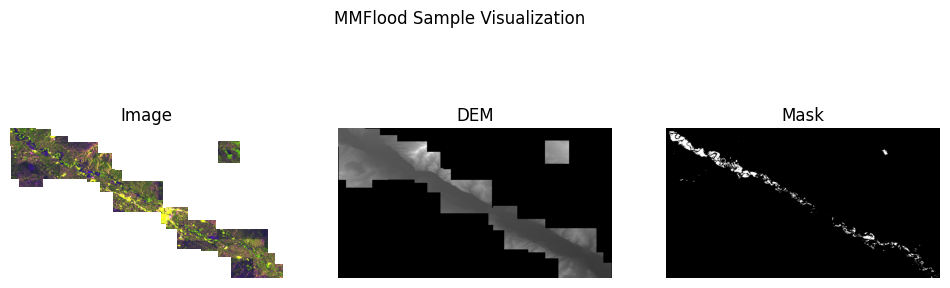

In [ ]:
# To get geometry of tiles
# geom = train_dataset.index['geometry'].iloc[12]
# print(list(geom.exterior.coords))

# Polygon coordinates
coords = [
    (-0.47885627639017, 41.44272176506629),
    (-0.47885627639017, 41.493588703533106),
    (-0.54734375, 41.493588703533106),
    (-0.54734375, 41.44272176506629),
    (-0.47885627639017, 41.44272176506629),
    (-1.3079116013156395, 41.8822770409637),
    (-1.3079116013156395, 41.945550784988),
    (-1.3991635179195094, 41.945550784988),
    (-1.3991635179195094, 41.8822770409637),
    (-1.3079116013156395, 41.8822770409637)
]

# coords= [(-0.8995133529999748, 43.65220712000007), (-0.8995133529999748, 43.70327907300003), (-1.0380790079999542, 43.70327907300003), (-1.0380790079999542, 43.65220712000007), (-0.8995133529999748, 43.65220712000007)]

plot_sample(coords=coords, dataset=train_dataset)

In [18]:
if apply_normalize==True:
    normalize=get_mmflood_normalize(include_dem=include_dem, include_hydro=include_hydro)
    train_dataset.transforms = normalize
    val_dataset.transforms = normalize
    test_dataset.transforms = normalize
else:
    train_dataset.transforms = None
    val_dataset.transforms = None
    test_dataset.transforms = None

#### Dataloader

In [20]:
patch_size=512
batch_size=16
train_size=8000
train_loader, val_loader, test_loader = get_loaders(train_dataset, val_dataset,test_dataset, patch_size, batch_size, train_size)

Train samples, 8000
Val samples, 631
Test samples, 2276
Train batches, 500
Val batches, 40
Test batches, 143


In [33]:
import torch

def get_class_weights(dataloader):
    
    num_classes = 2
    pixel_counts = torch.zeros(num_classes)
    
    for batch in dataloader:
        # batch is a dict with keys: 'image' and 'mask'
        # check type: batch['mask'] shape: [B, 1, H, W]
        mask = batch['mask']  # shape [B, 1, H, W]
        mask = mask.squeeze()  # remove extra dim, now [B, H, W]
    
        for c in range(num_classes):
            pixel_counts[c] += torch.sum(mask == c).item()
    
    total_pixels = pixel_counts.sum()
    class_weights = (total_pixels / (num_classes * pixel_counts)).float()
    
    print("Pixel counts per class:", pixel_counts)
    print("Class weights:", class_weights)
    return class_weights

_ = get_class_weights(train_loader)

Pixel counts per class: tensor([1.8804e+09, 9.7850e+07])
Class weights: tensor([ 0.5260, 10.1086])


### SegFormer (MIT-B0 Backbone)

## Experiment 1
- **Freeze backbone:** Yes
- **Freeze decoder:** No


#### Model Training

In [15]:
trainer, task, train_metrics = train_model(
    model_name="segformer",
    input_type="s1_dem",
    train_loader=train_loader,
    val_loader=val_loader,
    max_epochs=30, 
    batch_size=batch_size,
    patch_size=patch_size,
    in_channels=3,          # ← CHANGE THIS to match your actual number of bands!
    wandb_logging=True,
    freeze_backbone = True,      # keep encoder frozen
    freeze_decoder = False,
    loss="ce",
    backbone="mit_b0",
    learning_rate=0.0001,
    weights=True,
    class_weights=[ 0.5260, 10.1086]
)


Training batches count:  500
Experiment Name segformer_s1_dem_20260126_114750
Wandb logging.......


config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


using class_weights: [0.526, 10.1086]


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: rabinatwayana123 (rabinatwayana123-paris-lodron-universit-t-salzburg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ Segformer        │  3.7 M │ train │     0 │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │ train │     0 │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │     0 │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │     0 │
│ 4 │ test_metrics  │ MetricCollection │      0 │ train │     0 │
│ 5 │ loss          │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 395 K                                                                                            
Non-trainable params: 3.3 M                                                                                        
Total params: 3.7 M                                                                                                
Total estimated model params size (MB): 14                                                                         
Modules in train mode: 213                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_MulticlassF1Score_class1 improved. New best score: 0.099
Metric val_MulticlassF1Score_class1 improved by 0.009 >= min_delta = 1e-05. New best score: 0.108
Metric val_MulticlassF1Score_class1 improved by 0.008 >= min_delta = 1e-05. New best score: 0.116
Metric val_MulticlassF1Score_class1 improved by 0.019 >= min_delta = 1e-05. New best score: 0.135
Metric val_MulticlassF1Score_class1 improved by 0.024 >= min_delta = 1e-05. New best score: 0.159
Metric val_MulticlassF1Score_class1 improved by 0.004 >= min_delta = 1e-05. New best score: 0.163
Metric val_MulticlassF1Score_class1 improved by 0.011 >= min_delta = 1e-05. New best score: 0.174
Metric val_MulticlassF1Score_class1 improved by 0.004 >= min_delta = 1e-05. New best score: 0.178
Metric val_MulticlassF1Score_class1 improved by 0.007 >= min_delta = 1e-05. New best score: 0.185
Metric val_MulticlassF1Score_class1 improved by 0.003 >= min_delta = 1e-05. New best score: 0.188
Metric val_MulticlassF1Score_class1 improved by 0.

[2026-01-26 17:53:21] END: Model training (Duration: 21929.04s)

Metrics saved in metrics/segformer_s1_dem_20260126_114750/
Train metrics: {'val_loss': tensor(0.4526), 'val_MulticlassAccuracy': tensor(0.8174), 'val_MulticlassJaccardIndex': tensor(0.6912), 'val_MulticlassPrecision_class0': tensor(0.9884), 'val_MulticlassPrecision_class1': tensor(0.1150), 'val_MulticlassRecall_class0': tensor(0.8210), 'val_MulticlassRecall_class1': tensor(0.7076), 'val_MulticlassF1Score_class0': tensor(0.8970), 'val_MulticlassF1Score_class1': tensor(0.1978), 'train_loss': tensor(0.3191), 'train_MulticlassAccuracy': tensor(0.8535), 'train_MulticlassJaccardIndex': tensor(0.7445), 'train_MulticlassPrecision_class0': tensor(0.9933), 'train_MulticlassPrecision_class1': tensor(0.2380), 'train_MulticlassRecall_class0': tensor(0.8516), 'train_MulticlassRecall_class1': tensor(0.8905), 'train_MulticlassF1Score_class0': tensor(0.9170), 'train_MulticlassF1Score_class1': tensor(0.3756)}
Checkpoints saved in /kaggle/w

### Model Testing

In [ ]:
with custom_logger.step("Model testing"):
    test_metrics = trainer.test(
        model=task,
        dataloaders=test_loader,  # ← Your test dataloader
        ckpt_path="best"          # Uses your best checkpoint automatically
    )

Restoring states from the checkpoint path at ./MMFlood_DL_Experiments/teahfrgk/checkpoints/epoch=29-step=15000.ckpt
Loaded model weights from the checkpoint at ./MMFlood_DL_Experiments/teahfrgk/checkpoints/epoch=29-step=15000.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃           Test metric           ┃          DataLoader 0           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_MulticlassAccuracy     │       0.8558548092842102        │
│  test_MulticlassF1Score_class0  │       0.9207126498222351        │
│  test_MulticlassF1Score_class1  │       0.20795677602291107       │
│   test_MulticlassJaccardIndex   │        0.748029887676239        │
│ test_MulticlassPrecision_class0 │       0.9919593334197998        │
│ test_MulticlassPrecision_class1 │       0.12108176946640015       │
│  test_MulticlassRecall_class0   │       0.8590144515037537        │
│  test_MulticlassRecall_class1   │       0.7361046671867371        │
│            test_loss            │       0.4142215847969055        │
└─────────────────────────────────┴─────────────────────────────────┘

[2026-01-26 18:00:22] END: Model testing (Duration: 230.70s)



In [17]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
test_MulticlassAccuracy,▁
test_MulticlassF1Score_class0,▁
test_MulticlassF1Score_class1,▁
test_MulticlassJaccardIndex,▁
test_MulticlassPrecision_class0,▁
test_MulticlassPrecision_class1,▁
test_MulticlassRecall_class0,▁
test_MulticlassRecall_class1,▁
test_loss,▁
+19,...


### Result Metrics

In [ ]:
# import torch
# train_metrics = {
#     'val_loss': torch.tensor(0.4526),
#     'val_MulticlassAccuracy': torch.tensor(0.8174),
#     'val_MulticlassJaccardIndex': torch.tensor(0.6912),
#     'val_MulticlassPrecision_class0': torch.tensor(0.9884),
#     'val_MulticlassPrecision_class1': torch.tensor(0.1150),
#     'val_MulticlassRecall_class0': torch.tensor(0.8210),
#     'val_MulticlassRecall_class1': torch.tensor(0.7076),
#     'val_MulticlassF1Score_class0': torch.tensor(0.8970),
#     'val_MulticlassF1Score_class1': torch.tensor(0.1978),
#     'train_loss': torch.tensor(0.3191),
#     'train_MulticlassAccuracy': torch.tensor(0.8535),
#     'train_MulticlassJaccardIndex': torch.tensor(0.7445),
#     'train_MulticlassPrecision_class0': torch.tensor(0.9933),
#     'train_MulticlassPrecision_class1': torch.tensor(0.2380),
#     'train_MulticlassRecall_class0': torch.tensor(0.8516),
#     'train_MulticlassRecall_class1': torch.tensor(0.8905),
#     'train_MulticlassF1Score_class0': torch.tensor(0.9170),
#     'train_MulticlassF1Score_class1': torch.tensor(0.3756)
# }
# # Store test metrics in a plain Python dictionary
# test_metrics = {
#     "test_MulticlassAccuracy": 0.8558548092842102,
#     "test_MulticlassF1Score_class0": 0.9207126498222351,
#     "test_MulticlassF1Score_class1": 0.20795677602291107,
#     "test_MulticlassJaccardIndex": 0.748029887676239,
#     "test_MulticlassPrecision_class0": 0.9919593334197998,
#     "test_MulticlassPrecision_class1": 0.12108176946640015,
#     "test_MulticlassRecall_class0": 0.8590144515037537,
#     "test_MulticlassRecall_class1": 0.7361046671867371,
#     "test_loss": 0.4142215847969055
# }

In [ ]:
metrics= get_metrics(train_metrics, test_metrics[0])

print("=== Classwise Test Metrics ===")
print("\n---Test---")
classwise_test_metrics = show_classwise_metrics(test_metrics[0],stage="test")
print("\n---Val---")
classwise_val_metrics = show_classwise_metrics(train_metrics,stage="val")
print("\n---Train----")
classwise_train_metrics = show_classwise_metrics(train_metrics,stage="train")

Split    Train Validation  Test
Accuracy  0.85       0.82  0.86
Loss      0.32       0.45  0.41
F1_macro  0.65       0.55  0.56
=== Classwise Test Metrics ===

---Test---
          Class 0 Class 1
Precision   0.992   0.121
Recall      0.859   0.736
F1          0.921   0.208

---Val---
          Class 0 Class 1
Precision   0.988   0.115
Recall      0.821   0.708
F1          0.897   0.198

---Train----
          Class 0 Class 1
Precision   0.993   0.238
Recall      0.852   0.891
F1          0.917   0.376


/var/folders/z7/dwc0g9dx10n413p0gzrtz1lh0000gn/T/ipykernel_11197/2446007681.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")
/var/folders/z7/dwc0g9dx10n413p0gzrtz1lh0000gn/T/ipykernel_11197/2446007681.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")
/var/folders/z7/dwc0g9dx10n413p0gzrtz1lh0000gn/T/ipykernel_11197/2446007681.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")


In [ ]:

# metrics= get_metrics(train_metrics, test_metrics[0])

# print("=== Classwise Test Metrics ===")
# classwise_test_metrics = show_classwise_metrics(test_metrics[0])


Split    Train Validation  Test
Accuracy  0.85       0.82  0.86
Loss      0.32       0.45  0.41
F1_macro  1.10       1.00  1.02
=== Classwise Test Metrics ===
          Class 0 Class 1
Precision   0.992   0.121
Recall      0.859   0.736
F1          0.921   0.208


/tmp/ipykernel_55/804343284.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")


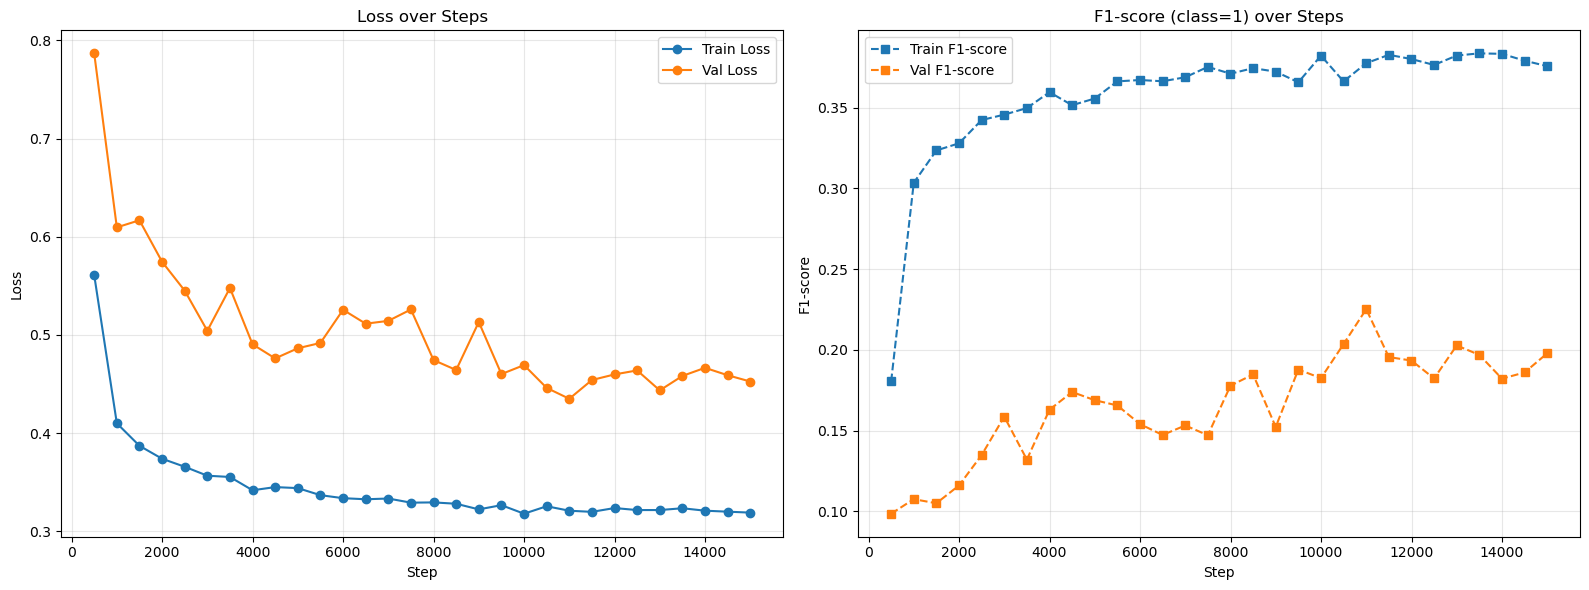

In [ ]:
# plot_graph("/Users/rabinatwayana/1_Rabina/3_CDE_III/DLCV/project_2/kaggle_result/Final/metric_seg_s1_dem_20260126_114750/metrics.csv")
plot_graph("/kaggle/working/metrics/segformer_s1_dem_20260126_114750/metrics.csv")

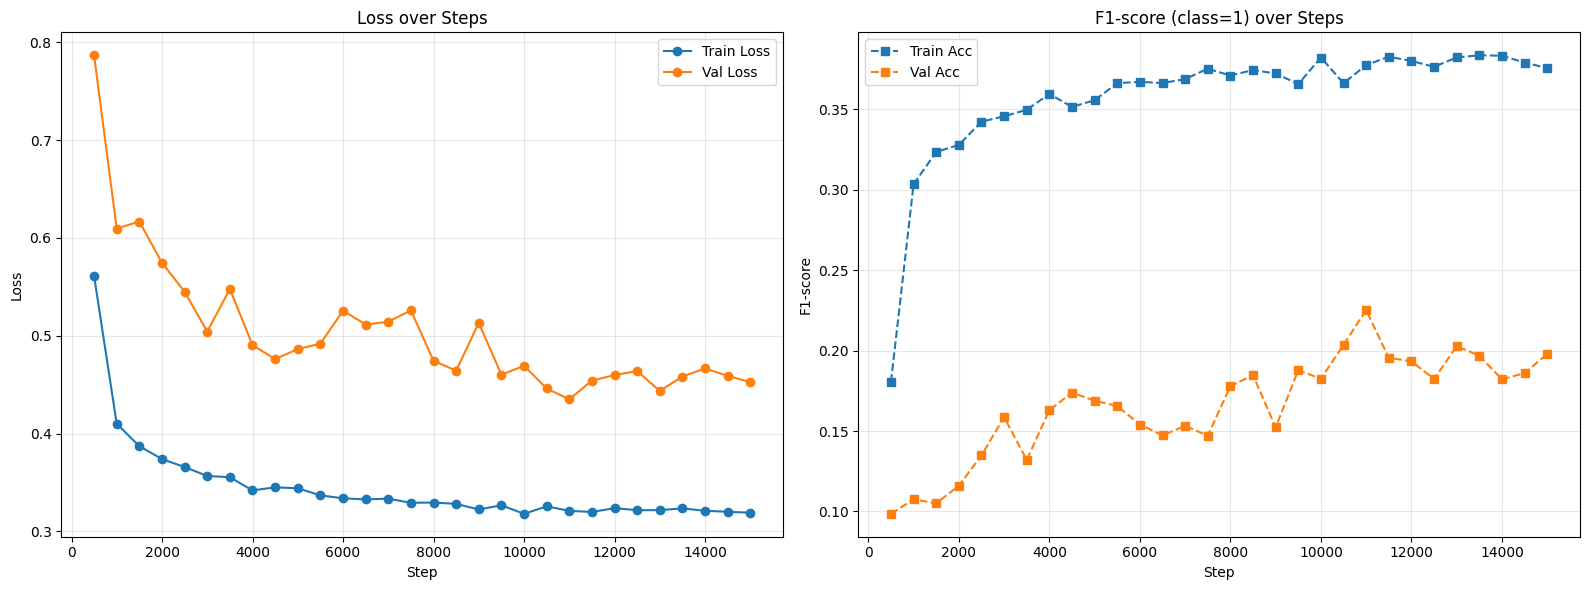

In [ ]:
# plot_graph("/kaggle/working/metrics/segformer_s1_dem_20260126_114750/metrics.csv")

In [ ]:
# Zipping output in kaggle to download

shutil.make_archive(
    "/kaggle/working/zipped/ckpt_seg_s1_dem_20260126_114750", 
    'zip', 
    "/kaggle/working/checkpoints/segformer_s1_dem_20260126_114750"
)

shutil.make_archive(
    "/kaggle/working/zipped/metric_seg_s1_dem_20260126_114750", 
    'zip', 
    "/kaggle/working/metrics/segformer_s1_dem_20260126_114750/"
)

'/kaggle/working/zipped/metric_seg_s1_dem_20260126_114750.zip'

## Experiment 2
- **Freeze backbone:** No
- **Freeze decoder:** No
- **Weight**: Imagenet


In [37]:

trainer_full_2, task_full_2, train_metrics_full_2 = train_model(
    model_name="segformer",
    input_type="s1_dem",
    train_loader=train_loader,
    val_loader=val_loader,
    max_epochs=30, 
    batch_size=batch_size,
    patch_size=patch_size,
    in_channels=3,          # ← CHANGE THIS to match your actual number of bands!
    wandb_logging=True,
    freeze_backbone = False,      # keep encoder frozen
    freeze_decoder = False,
    loss="ce",
    backbone="mit_b0",
    learning_rate=3e-5,
    class_weights=[ 0.5260, 10.1086]
)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Training batches count:  500
Experiment Name segformer_s1_dem_20260125_142235
Wandb logging.......
using class_weights: [0.526, 10.1086]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ Segformer        │  3.7 M │ train │     0 │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │ train │     0 │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │     0 │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │     0 │
│ 4 │ test_metrics  │ MetricCollection │      0 │ train │     0 │
│ 5 │ loss          │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 3.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.7 M                                                                                                
Total estimated model params size (MB): 14                                                                         
Modules in train mode: 213                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_MulticlassF1Score_class1 improved. New best score: 0.088
Metric val_MulticlassF1Score_class1 improved by 0.013 >= min_delta = 1e-05. New best score: 0.101
Metric val_MulticlassF1Score_class1 improved by 0.034 >= min_delta = 1e-05. New best score: 0.135
Metric val_MulticlassF1Score_class1 improved by 0.054 >= min_delta = 1e-05. New best score: 0.189
Metric val_MulticlassF1Score_class1 improved by 0.121 >= min_delta = 1e-05. New best score: 0.310
Metric val_MulticlassF1Score_class1 improved by 0.022 >= min_delta = 1e-05. New best score: 0.332
Metric val_MulticlassF1Score_class1 improved by 0.004 >= min_delta = 1e-05. New best score: 0.336
Metric val_MulticlassF1Score_class1 improved by 0.037 >= min_delta = 1e-05. New best score: 0.373
Monitored metric val_MulticlassF1Score_class1 did not improve in the last 8 records. Best score: 0.373. Signaling Trainer to stop.


[2026-01-25 16:49:54] END: Model training (Duration: 8838.15s)

Metrics saved in metrics/segformer_s1_dem_20260125_142235/
Train metrics: {'val_loss': tensor(0.3150), 'val_MulticlassAccuracy': tensor(0.9232), 'val_MulticlassJaccardIndex': tensor(0.8574), 'val_MulticlassPrecision_class0': tensor(0.9896), 'val_MulticlassPrecision_class1': tensor(0.2494), 'val_MulticlassRecall_class0': tensor(0.9304), 'val_MulticlassRecall_class1': tensor(0.7032), 'val_MulticlassF1Score_class0': tensor(0.9591), 'val_MulticlassF1Score_class1': tensor(0.3682), 'train_loss': tensor(0.2744), 'train_MulticlassAccuracy': tensor(0.8752), 'train_MulticlassJaccardIndex': tensor(0.7781), 'train_MulticlassPrecision_class0': tensor(0.9945), 'train_MulticlassPrecision_class1': tensor(0.2760), 'train_MulticlassRecall_class0': tensor(0.8734), 'train_MulticlassRecall_class1': tensor(0.9092), 'train_MulticlassF1Score_class0': tensor(0.9300), 'train_MulticlassF1Score_class1': tensor(0.4234)}
Checkpoints saved in /kaggle/wo

In [38]:
with custom_logger.step("Model testing"):
    test_metrics_full_2 = trainer_full_2.test(
        model=task_full_2,
        dataloaders=test_loader,  # ← Your test dataloader
        ckpt_path="best"          # Uses your best checkpoint automatically
    )

wandb.finish()

Restoring states from the checkpoint path at ./MMFlood_DL_Experiments/h9ms303i/checkpoints/epoch=15-step=8000.ckpt
Loaded model weights from the checkpoint at ./MMFlood_DL_Experiments/h9ms303i/checkpoints/epoch=15-step=8000.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃           Test metric           ┃          DataLoader 0           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_MulticlassAccuracy     │       0.9352977275848389        │
│  test_MulticlassF1Score_class0  │       0.9658837914466858        │
│  test_MulticlassF1Score_class1  │       0.37470075488090515       │
│   test_MulticlassJaccardIndex   │       0.8784592747688293        │
│ test_MulticlassPrecision_class0 │       0.9931457042694092        │
│ test_MulticlassPrecision_class1 │       0.24928225576877594       │
│  test_MulticlassRecall_class0   │       0.9400785565376282        │
│  test_MulticlassRecall_class1   │        0.754104733467102        │
│            test_loss            │       0.3203932046890259        │
└─────────────────────────────────┴─────────────────────────────────┘

[2026-01-25 16:57:59] END: Model testing (Duration: 132.42s)



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
test_MulticlassAccuracy,▁
test_MulticlassF1Score_class0,▁
test_MulticlassF1Score_class1,▁
test_MulticlassJaccardIndex,▁
test_MulticlassPrecision_class0,▁
test_MulticlassPrecision_class1,▁
test_MulticlassRecall_class0,▁
test_MulticlassRecall_class1,▁
test_loss,▁
+19,...


In [33]:
# Store train/validation metrics in a Python dictionary
train_metrics_full_2 = {
    'train_loss': 0.2744,
    'train_MulticlassAccuracy': 0.8752,
    'train_MulticlassJaccardIndex': 0.7781,
    'train_MulticlassPrecision_class0': 0.9945,
    'train_MulticlassPrecision_class1': 0.2760,
    'train_MulticlassRecall_class0': 0.8734,
    'train_MulticlassRecall_class1': 0.9092,
    'train_MulticlassF1Score_class0': 0.9300,
    'train_MulticlassF1Score_class1': 0.4234,
    
    'val_loss': 0.3150,
    'val_MulticlassAccuracy': 0.9232,
    'val_MulticlassJaccardIndex': 0.8574,
    'val_MulticlassPrecision_class0': 0.9896,
    'val_MulticlassPrecision_class1': 0.2494,
    'val_MulticlassRecall_class0': 0.9304,
    'val_MulticlassRecall_class1': 0.7032,
    'val_MulticlassF1Score_class0': 0.9591,
    'val_MulticlassF1Score_class1': 0.3682
}

test_metrics_full_2 = {
    "test_MulticlassAccuracy": 0.9352977275848389,
    "test_MulticlassF1Score_class0": 0.9658837914466858,
    "test_MulticlassF1Score_class1": 0.37470075488090515,
    "test_MulticlassJaccardIndex": 0.8784592747688293,
    "test_MulticlassPrecision_class0": 0.9931457042694092,
    "test_MulticlassPrecision_class1": 0.24928225576877594,
    "test_MulticlassRecall_class0": 0.9400785565376282,
    "test_MulticlassRecall_class1": 0.754104733467102,
    "test_loss": 0.3203932046890259
}


# Example usage


In [ ]:
metrics_full_2= get_metrics(train_metrics_full_2, test_metrics_full_2[0])

print("=== Classwise Test Metrics ===")
print("\n---Test---")
classwise_test_metrics = show_classwise_metrics(test_metrics_full_2[0],stage="test")
print("\n---Val---")
classwise_val_metrics = show_classwise_metrics(train_metrics_full_2,stage="val")
print("\n---Train----")
classwise_train_metrics = show_classwise_metrics(train_metrics_full_2,stage="train")

Split    Train Validation  Test
Accuracy  0.88       0.92  0.94
Loss      0.27       0.32  0.32
F1_macro  0.68       0.66  0.67
=== Classwise Test Metrics ===

---Test---
          Class 0 Class 1
Precision   0.993   0.249
Recall      0.940   0.754
F1          0.966   0.375

---Val---
          Class 0 Class 1
Precision   0.990   0.249
Recall      0.930   0.703
F1          0.959   0.368

---Train----
          Class 0 Class 1
Precision   0.995   0.276
Recall      0.873   0.909
F1          0.930   0.423


/var/folders/z7/dwc0g9dx10n413p0gzrtz1lh0000gn/T/ipykernel_11197/2446007681.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")
/var/folders/z7/dwc0g9dx10n413p0gzrtz1lh0000gn/T/ipykernel_11197/2446007681.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")
/var/folders/z7/dwc0g9dx10n413p0gzrtz1lh0000gn/T/ipykernel_11197/2446007681.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")


In [ ]:
# metrics_full_2= get_metrics(train_metrics_full_2, test_metrics_full_2[0])

# print("=== Classwise Test Metrics ===")
# classwise_test_metrics_full_2 = show_classwise_metrics(test_metrics_full_2[0])

Split    Train Validation  Test
Accuracy  0.88       0.92  0.94
Loss      0.27       0.32  0.32
F1_macro  1.14       1.14  1.15
=== Classwise Test Metrics ===
          Class 0 Class 1
Precision   0.993   0.249
Recall      0.940   0.754
F1          0.966   0.375


/tmp/ipykernel_132/1744260567.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")


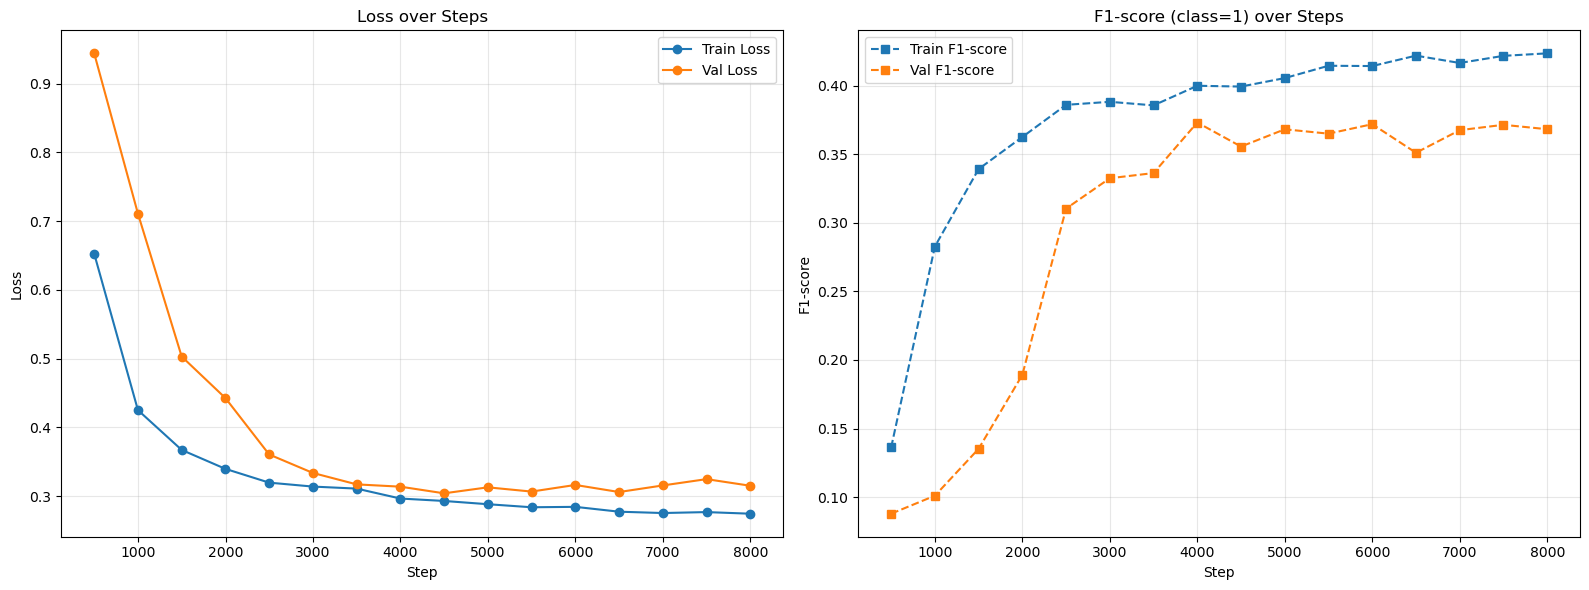

In [ ]:
# plot_graph("/Users/rabinatwayana/1_Rabina/3_CDE_III/DLCV/project_2/kaggle_result/03_01_142235_full_train_claswight_safari/metric_seg_s1_dem_20260125_142235/metrics.csv")

plot_graph("/kaggle/working/metrics/segformer_s1_dem_20260125_142235/metrics.csv")


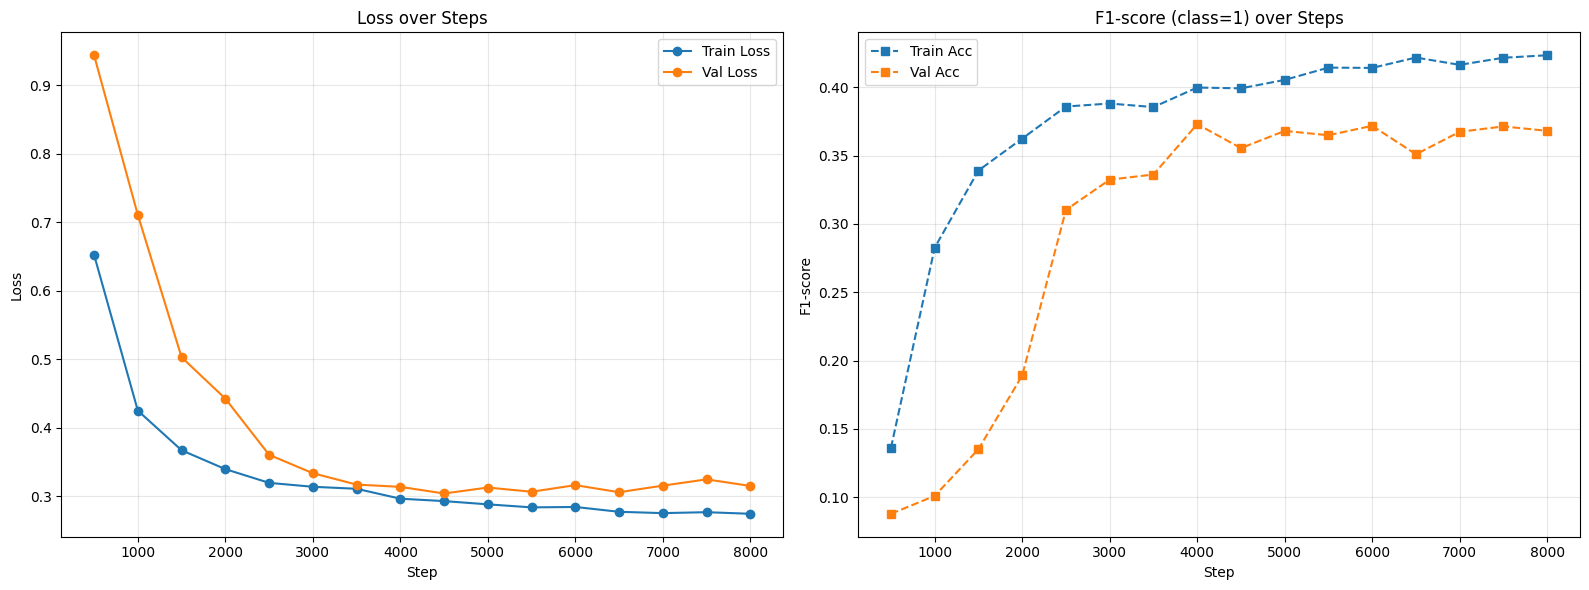

In [42]:
plot_graph("/kaggle/working/metrics/segformer_s1_dem_20260125_142235/metrics.csv")

In [ ]:
# zip results to export from kaggle
shutil.make_archive(
    "/kaggle/working/zipped/ckpt_seg_s1_dem_20260125_142235", 
    'zip', 
    "/kaggle/working/checkpoints/segformer_s1_dem_20260125_142235"
)

shutil.make_archive(
    "/kaggle/working/zipped/metric_seg_s1_dem_20260125_142235", 
    'zip', 
    "/kaggle/working/metrics/segformer_s1_dem_20260125_142235/"
)

'/kaggle/working/zipped/metric_seg_s1_dem_20260125_142235.zip'

### Experiment 3

In [9]:
train_dataset, val_dataset, test_dataset = load_dataset(
    root_data_dir=root_data_dir, 
    include_hydro=include_hydro, 
    include_dem=include_dem)



[2026-01-26 02:23:43] END: Loading train dataset (Duration: 24.28s)

[2026-01-26 02:23:45] END: Loading val dataset (Duration: 2.56s)

[2026-01-26 02:23:53] END: Loading test dataset (Duration: 8.04s)

Train tiles: 1242
Val tiles: 120
Test tiles: 386


In [ ]:
def get_channel_percentiles(dataloader, include_dem=False, lower=0.01, upper=0.99, max_samples=500, pixel_sample=10000):
    """
    Compute per-channel percentiles (like min/max but robust) for core channels.
    
    dataloader: yields batches with 'image' key [B, C, H, W]
    include_dem: whether DEM channel exists (3rd channel)
    lower, upper: percentiles (0-1)
    max_samples: max number of batches to scan
    pixel_sample: max number of pixels to randomly sample per batch for efficiency
    """
    core_channels = 2 + int(include_dem)
    all_pixels = []

    for i, batch in enumerate(dataloader):
        if i >= max_samples:
            break

        img = batch['image'].float()  # [B, C, H, W]
        img = img[:, :core_channels]  # only core channels

        # Flatten batch and spatial dims: [B, C, H, W] -> [B*H*W, C]
        pixels = img.permute(0, 2, 3, 1).reshape(-1, core_channels)

        # Remove NaN/Inf
        pixels = pixels[torch.isfinite(pixels).all(dim=1)]

        # Randomly sample pixels for efficiency
        if pixels.shape[0] > pixel_sample:
            idx = torch.randperm(pixels.shape[0])[:pixel_sample]
            pixels = pixels[idx]

        all_pixels.append(pixels)

    # Concatenate all pixels across batches
    all_pixels = torch.cat(all_pixels, dim=0)  # [N, C]

    # Compute per-channel percentiles
    mins = torch.quantile(all_pixels, lower, dim=0)
    maxs = torch.quantile(all_pixels, upper, dim=0)

    print("Per-channel lower percentile:", mins)
    print("Per-channel upper percentile:", maxs)
    return mins, maxs



def get_mmflood_normalize_img_net(
    mins_core,      
    maxs_core,      
    include_dem: bool,
    include_hydro: bool,
    eps=1e-6
):
    # Standard ImageNet stats
    in_mean = [0.485, 0.456, 0.406]
    in_std  = [0.229, 0.224, 0.225]

    # Calculate 4th channel stats (average of RGB) to keep it stable
    hydro_mean = sum(in_mean) / 3.0
    hydro_std  = sum(in_std) / 3.0
    
    # Final normalization tensors
    total_mean = in_mean + ([hydro_mean] if include_hydro else [])
    total_std  = in_std + ([hydro_std] if include_hydro else [])
    
    m_imgnet = torch.tensor(total_mean).view(-1, 1, 1)
    s_imgnet = torch.tensor(total_std).view(-1, 1, 1)
    
    m_core = torch.tensor(mins_core).view(-1, 1, 1)
    M_core = torch.tensor(maxs_core).view(-1, 1, 1)

    def normalize(sample):
        img = sample["image"].float()  # Expected shape (C, H, W)
        
        # 1. Step: Physical Units -> [0, 1] Range
        # Normalize the Core (VV, VH, DEM)
        core_count = 2 + int(include_dem)
        core = img[:core_count]
        core = torch.clamp(core, m_core, M_core)
        core = (core - m_core) / (M_core - m_core + eps)

        # Normalize Hydro (already 0-1, just clamp for safety)
        if include_hydro:
            hydro = img[-1:] 
            hydro = torch.clamp(hydro, 0.0, 1.0)
            img = torch.cat([core, hydro], dim=0)
        else:
            img = core

        # 2. Step: ImageNet Standardization
        # Shifts data so mean is ~0 and std is ~1 as seen in pre-training
        sample["image"] = (img - m_imgnet) / s_imgnet
        return sample

    return normalize

In [33]:
# get_channel_min_max(train_loader, include_dem=include_dem,max_samples=2000)

Per-channel min: tensor([    0.0000,     0.0000, -7549.0537])
Per-channel max: tensor([4125.8979,  428.0628, 1842.8317])


(tensor([    0.0000,     0.0000, -7549.0537]),
 tensor([4125.8979,  428.0628, 1842.8317]))

In [11]:
patch_size=512
batch_size=16
train_size=500
train_loader, val_loader, test_loader = get_loaders(train_dataset, val_dataset,test_dataset, patch_size, batch_size, train_size)

Train samples, 500
Val samples, 631
Test samples, 2276
Train batches, 32
Val batches, 40
Test batches, 143


In [37]:
mins, maxs = get_channel_percentiles(
    train_loader,
    include_dem=True,
    lower=0.01,
    upper=0.99,
    max_samples=500,
    pixel_sample=10000  # max pixels per batch to sample for speed
)

Per-channel lower percentile: tensor([ 0.,  0., -3.])
Per-channel upper percentile: tensor([8.5270e-01, 1.5705e-01, 1.1395e+03])


In [12]:
with custom_logger.step("Get channel percentile"):
    mins, maxs = get_channel_percentiles(
        train_loader,
        include_dem=True,
        lower=0.01,
        upper=0.99,
        max_samples=1000,
        pixel_sample=10000  # max pixels per batch to sample for speed
    )

Per-channel lower percentile: tensor([ 0.,  0., -4.])
Per-channel upper percentile: tensor([9.4352e-01, 1.6332e-01, 1.1340e+03])
[2026-01-26 02:25:41] END: Get channel percentile (Duration: 107.13s)



In [14]:
# mins_c = torch.tensor([0.0, 0.0, -3.0], dtype=torch.float32)
# maxs_c = torch.tensor([0.9435, 0.16332, 1135], dtype=torch.float32)
mins_c = [0.0, 0.0, -3.0]
maxs_c = [0.9435, 0.16332, 1135]

if apply_normalize==True:
    print("Apply normalize")
    normalize=get_mmflood_normalize_img_net(
    mins_core=mins_c,
    maxs_core=maxs_c,
    include_dem=include_dem,
    include_hydro=False,
    # hydro_min=0.0,
    # hydro_max=1.0,
    eps=1e-6
)
    train_dataset.transforms = normalize
    val_dataset.transforms = normalize
    test_dataset.transforms = normalize
else:
    train_dataset.transforms = None
    val_dataset.transforms = None
    test_dataset.transforms = None

Apply normalize


In [ ]:
def normalize_sanity_check(dataset,coords):
    xs, ys = zip(*coords)
    xmin, xmax = min(xs), max(xs)
    ymin, ymax = min(ys), max(ys)
    
    # train_dataset.transforms = None
    # Spatial resolution (adjust to match your dataset!)
    xres = 0.001   # ~100 meters at equator
    yres = 0.001
    
    # Time range (example: full year 2023, daily steps)
    t_start = pd.Timestamp("2014-01-01")
    t_end   = pd.Timestamp("2021-12-31")
    tres    = 1   # or "P1D"


    query = (
        slice(xmin, xmax, xres),
        slice(ymin, ymax, yres),
        # slice(pd.Timestamp("2023-01-01"), pd.Timestamp("2023-12-31"), 1)
        slice(t_start, t_end, tres)
    
    )
    
    sample = dataset.__getitem__(query=query)
    img = sample['image']
    
    for c in range(img.shape[0]):
        print(f"Channel {c}: min={img[c].min():.4f}, max={img[c].max():.4f}, mean={img[c].mean():.4f}")


coords = [
        (-0.47885627639017, 41.44272176506629),
        (-0.47885627639017, 41.493588703533106),
        (-0.54734375, 41.493588703533106),
        (-0.54734375, 41.44272176506629),
        (-0.47885627639017, 41.44272176506629),
        (-1.3079116013156395, 41.8822770409637),
        (-1.3079116013156395, 41.945550784988),
        (-1.3991635179195094, 41.945550784988),
        (-1.3991635179195094, 41.8822770409637),
        (-1.3079116013156395, 41.8822770409637)
    ]

normalize_sanity_check(train_dataset,coords)

Channel 0: min=-2.1179, max=2.2489, mean=-1.9493
Channel 1: min=-2.0357, max=2.4285, mean=-1.8774
Channel 2: min=-1.7927, max=0.8129, mean=-1.5059


In [26]:
patch_size=512
batch_size=16
train_size=8000
train_loader, val_loader, test_loader = get_loaders(train_dataset, val_dataset,test_dataset, patch_size, batch_size, train_size)

Train samples, 8000
Val samples, 631
Test samples, 2276
Train batches, 500
Val batches, 40
Test batches, 143


In [ ]:
trainer_2, task_2, train_metrics_2 = train_model(
    model_name="segformer",
    input_type="s1_dem",
    train_loader=train_loader,
    val_loader=val_loader,
    max_epochs=30, 
    batch_size=batch_size,
    patch_size=patch_size,
    in_channels=3,          # ← CHANGE THIS to match your actual number of bands!
    wandb_logging=True,
    freeze_backbone = True,      # keep encoder frozen
    freeze_decoder = False,
    loss="ce",
    backbone="mit_b0",
    learning_rate=0.0001,
    class_weights=[ 0.5260, 10.1086]
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Training batches count:  500
Experiment Name segformer_s1_dem_20260126_024406
Wandb logging.......
using class_weights: [0.526, 10.1086]


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: rabinatwayana123 (rabinatwayana123-paris-lodron-universit-t-salzburg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ Segformer        │  3.7 M │ train │     0 │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │ train │     0 │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │     0 │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │     0 │
│ 4 │ test_metrics  │ MetricCollection │      0 │ train │     0 │
│ 5 │ loss          │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 395 K                                                                                            
Non-trainable params: 3.3 M                                                                                        
Total params: 3.7 M                                                                                                
Total estimated model params size (MB): 14                                                                         
Modules in train mode: 213                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_MulticlassF1Score_class1 improved. New best score: 0.097
Metric val_MulticlassF1Score_class1 improved by 0.001 >= min_delta = 1e-05. New best score: 0.098
Metric val_MulticlassF1Score_class1 improved by 0.003 >= min_delta = 1e-05. New best score: 0.101
Metric val_MulticlassF1Score_class1 improved by 0.001 >= min_delta = 1e-05. New best score: 0.102
Metric val_MulticlassF1Score_class1 improved by 0.001 >= min_delta = 1e-05. New best score: 0.103
Metric val_MulticlassF1Score_class1 improved by 0.000 >= min_delta = 1e-05. New best score: 0.103
Metric val_MulticlassF1Score_class1 improved by 0.005 >= min_delta = 1e-05. New best score: 0.109
Metric val_MulticlassF1Score_class1 improved by 0.010 >= min_delta = 1e-05. New best score: 0.119
Metric val_MulticlassF1Score_class1 improved by 0.004 >= min_delta = 1e-05. New best score: 0.123
Metric val_MulticlassF1Score_class1 improved by 0.002 >= min_delta = 1e-05. New best score: 0.125


In [30]:
with custom_logger.step("Model testing"):
    test_metrics_2 = trainer_2.test(
        model=task_2,
        dataloaders=test_loader,  # ← Your test dataloader
        ckpt_path="best"          # Uses your best checkpoint automatically
    )

wandb.finish()

Restoring states from the checkpoint path at ./MMFlood_DL_Experiments/nosehvrb/checkpoints/epoch=27-step=14000.ckpt
Loaded model weights from the checkpoint at ./MMFlood_DL_Experiments/nosehvrb/checkpoints/epoch=27-step=14000.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃           Test metric           ┃          DataLoader 0           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_MulticlassAccuracy     │       0.6963520646095276        │
│  test_MulticlassF1Score_class0  │        0.816887617111206        │
│  test_MulticlassF1Score_class1  │       0.11146386712789536       │
│   test_MulticlassJaccardIndex   │       0.5341565012931824        │
│ test_MulticlassPrecision_class0 │       0.9902607202529907        │
│ test_MulticlassPrecision_class1 │       0.06026536971330643       │
│  test_MulticlassRecall_class0   │       0.6951772570610046        │
│  test_MulticlassRecall_class1   │       0.7408745884895325        │
│            test_loss            │       0.5135827660560608        │
└─────────────────────────────────┴─────────────────────────────────┘

[2026-01-26 08:15:25] END: Model testing (Duration: 204.22s)



epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
test_MulticlassAccuracy,▁
test_MulticlassF1Score_class0,▁
test_MulticlassF1Score_class1,▁
test_MulticlassJaccardIndex,▁
test_MulticlassPrecision_class0,▁
test_MulticlassPrecision_class1,▁
test_MulticlassRecall_class0,▁
test_MulticlassRecall_class1,▁
test_loss,▁
+19,...


In [31]:
metrics_2= get_metrics(train_metrics_2, test_metrics_2[0])

print("=== Classwise Test Metrics ===")
print("\n---Test---")
classwise_test_metrics_2 = show_classwise_metrics(test_metrics_2[0],stage="test")
print("\n---Val---")
classwise_val_metrics_2 = show_classwise_metrics(train_metrics_2,stage="val")
print("\n---Train----")
classwise_train_metrics_2 = show_classwise_metrics(train_metrics_2,stage="train")


Split    Train Validation  Test
Accuracy  0.87       0.65  0.70
Loss      0.31       0.58  0.51
F1_macro  1.12       0.84  0.87
=== Classwise Test Metrics ===

---Test---
          Class 0 Class 1
Precision   0.990   0.060
Recall      0.695   0.741
F1          0.817   0.111

---Val---
          Class 0 Class 1
Precision   0.983   0.058
Recall      0.651   0.654
F1          0.783   0.106

---Train----
          Class 0 Class 1
Precision   0.994   0.258
Recall      0.864   0.893
F1          0.924   0.400


/tmp/ipykernel_55/331210062.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")
/tmp/ipykernel_55/331210062.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")
/tmp/ipykernel_55/331210062.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")


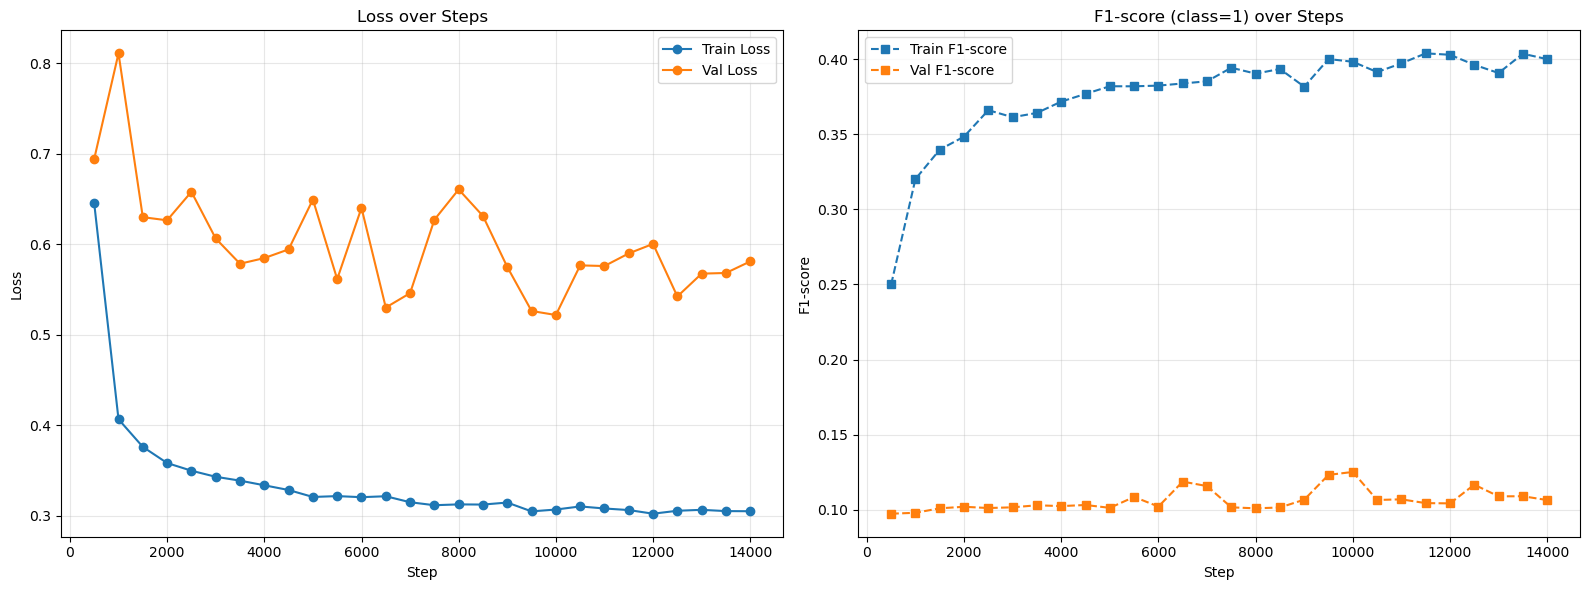

In [ ]:
# plot_graph("/Users/rabinatwayana/1_Rabina/3_CDE_III/DLCV/project_2/kaggle_result/03_01_01__o24406_train_imgnet_transpose/metric_seg_s1_dem_20260126_024406/metrics.csv")
plot_graph("/kaggle/working/metrics/segformer_s1_dem_20260126_024406/metrics.csv")


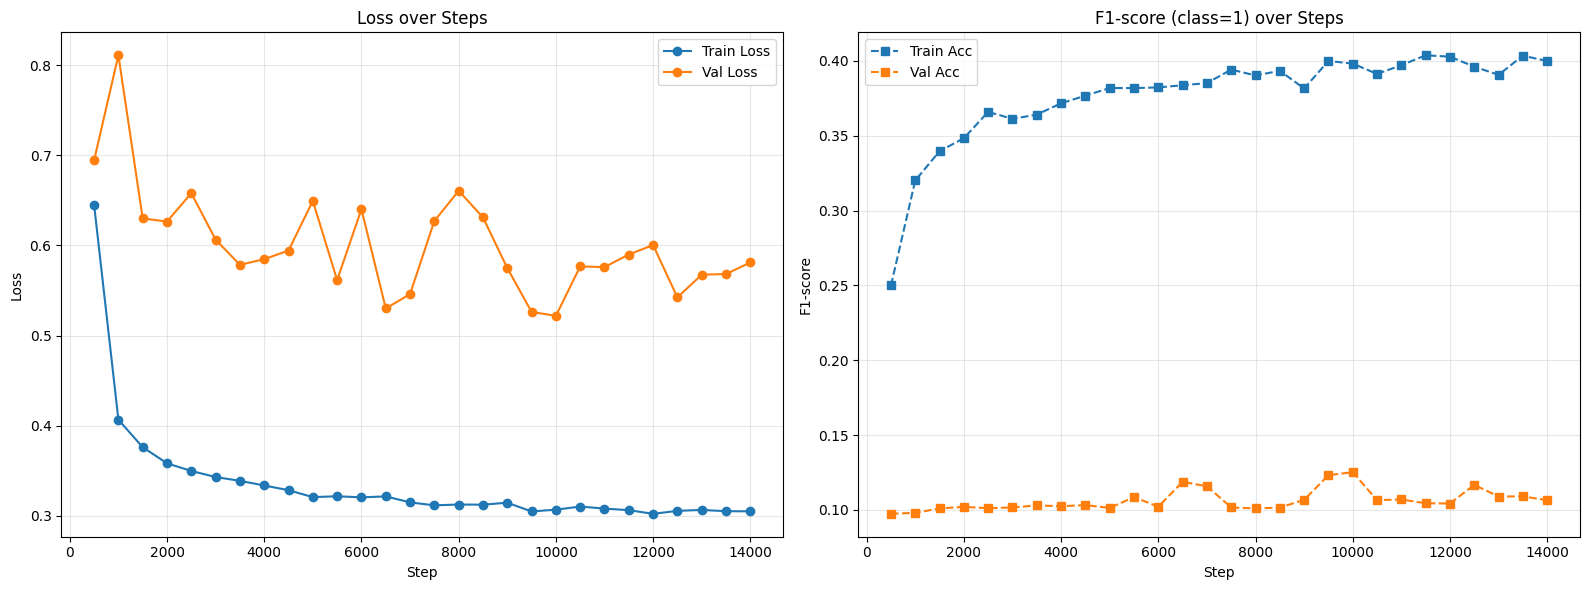

In [ ]:
# plot_graph("/kaggle/working/metrics/segformer_s1_dem_20260126_024406/metrics.csv")

In [ ]:
shutil.make_archive(
    "/kaggle/working/zipped/ckpt_seg_s1_dem_20260126_024406", 
    'zip', 
    "/kaggle/working/checkpoints/segformer_s1_dem_20260126_024406"
)

shutil.make_archive(
    "/kaggle/working/zipped/metric_seg_s1_dem_20260126_024406", 
    'zip', 
    "/kaggle/working/metrics/segformer_s1_dem_20260126_024406"
)

'/kaggle/working/zipped/metric_seg_s1_dem_20260126_024406.zip'

##

### Experiment 4 
- freeze_backbone: No   
- freeze_decoder: No
- weights: None

In [12]:
trainer_full_3, task_full_3, train_metrics_full_3 = train_model(
    model_name="segformer",
    input_type="s1_dem",
    train_loader=train_loader,
    val_loader=val_loader,
    max_epochs=30, 
    batch_size=batch_size,
    patch_size=patch_size,
    in_channels=3,          # ← CHANGE THIS to match your actual number of bands!
    wandb_logging=True,
    freeze_backbone = False,      # keep encoder frozen
    freeze_decoder = False,
    loss="ce",
    backbone="mit_b0",
    learning_rate=3e-5,
    weights=False,
    class_weights=[ 0.5260, 10.1086]
)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Training batches count:  500
Experiment Name segformer_s1_dem_20260126_071551
Wandb logging.......
using class_weights: [0.526, 10.1086]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: rabinatwayana123 (rabinatwayana123-paris-lodron-universit-t-salzburg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ Segformer        │  3.7 M │ train │     0 │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │ train │     0 │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │     0 │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │     0 │
│ 4 │ test_metrics  │ MetricCollection │      0 │ train │     0 │
│ 5 │ loss          │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 3.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.7 M                                                                                                
Total estimated model params size (MB): 14                                                                         
Modules in train mode: 213                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_MulticlassF1Score_class1 improved. New best score: 0.078
Metric val_MulticlassF1Score_class1 improved by 0.013 >= min_delta = 1e-05. New best score: 0.090
Metric val_MulticlassF1Score_class1 improved by 0.001 >= min_delta = 1e-05. New best score: 0.091
Metric val_MulticlassF1Score_class1 improved by 0.001 >= min_delta = 1e-05. New best score: 0.092
Metric val_MulticlassF1Score_class1 improved by 0.000 >= min_delta = 1e-05. New best score: 0.092
Metric val_MulticlassF1Score_class1 improved by 0.002 >= min_delta = 1e-05. New best score: 0.095
Metric val_MulticlassF1Score_class1 improved by 0.000 >= min_delta = 1e-05. New best score: 0.095
Metric val_MulticlassF1Score_class1 improved by 0.001 >= min_delta = 1e-05. New best score: 0.095
Metric val_MulticlassF1Score_class1 improved by 0.000 >= min_delta = 1e-05. New best score: 0.096
Metric val_MulticlassF1Score_class1 improved by 0.000 >= min_delta = 1e-05. New best score: 0.096
`Trainer.fit` stopped: `max_epochs=30` reached.


[2026-01-26 12:49:46] END: Model training (Duration: 20034.82s)

Metrics saved in metrics/segformer_s1_dem_20260126_071551/
Train metrics: {'val_loss': tensor(0.7689), 'val_MulticlassAccuracy': tensor(0.5888), 'val_MulticlassJaccardIndex': tensor(0.4172), 'val_MulticlassPrecision_class0': tensor(0.9824), 'val_MulticlassPrecision_class1': tensor(0.0512), 'val_MulticlassRecall_class0': tensor(0.5858), 'val_MulticlassRecall_class1': tensor(0.6806), 'val_MulticlassF1Score_class0': tensor(0.7339), 'val_MulticlassF1Score_class1': tensor(0.0953), 'train_loss': tensor(0.4112), 'train_MulticlassAccuracy': tensor(0.7974), 'train_MulticlassJaccardIndex': tensor(0.6631), 'train_MulticlassPrecision_class0': tensor(0.9904), 'train_MulticlassPrecision_class1': tensor(0.1776), 'train_MulticlassRecall_class0': tensor(0.7946), 'train_MulticlassRecall_class1': tensor(0.8518), 'train_MulticlassF1Score_class0': tensor(0.8818), 'train_MulticlassF1Score_class1': tensor(0.2939)}
Checkpoints saved in /kaggle/w

In [13]:
with custom_logger.step("Model testing"):
    test_metrics_full_3 = trainer_full_3.test(
        model=task_full_3,
        dataloaders=test_loader,  # ← Your test dataloader
        ckpt_path="best"          # Uses your best checkpoint automatically
    )

wandb.finish()

Restoring states from the checkpoint path at ./MMFlood_DL_Experiments/wazntahg/checkpoints/epoch=29-step=15000.ckpt
Loaded model weights from the checkpoint at ./MMFlood_DL_Experiments/wazntahg/checkpoints/epoch=29-step=15000.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃           Test metric           ┃          DataLoader 0           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_MulticlassAccuracy     │       0.6244505047798157        │
│  test_MulticlassF1Score_class0  │       0.7632161378860474        │
│  test_MulticlassF1Score_class1  │       0.09278067946434021       │
│   test_MulticlassJaccardIndex   │       0.4539644122123718        │
│ test_MulticlassPrecision_class0 │       0.9893688559532166        │
│ test_MulticlassPrecision_class1 │       0.04946199059486389       │
│  test_MulticlassRecall_class0   │       0.6212166547775269        │
│  test_MulticlassRecall_class1   │       0.7470123171806335        │
│            test_loss            │       0.6923331618309021        │
└─────────────────────────────────┴─────────────────────────────────┘

[2026-01-26 13:00:59] END: Model testing (Duration: 227.34s)



epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
test_MulticlassAccuracy,▁
test_MulticlassF1Score_class0,▁
test_MulticlassF1Score_class1,▁
test_MulticlassJaccardIndex,▁
test_MulticlassPrecision_class0,▁
test_MulticlassPrecision_class1,▁
test_MulticlassRecall_class0,▁
test_MulticlassRecall_class1,▁
test_loss,▁
+19,...


In [6]:
train_metrics_full_3 = {
    "train_loss": 0.4112,
    "train_MulticlassAccuracy": 0.7974,
    "train_MulticlassJaccardIndex": 0.6631,
    "train_MulticlassPrecision_class0": 0.9904,
    "train_MulticlassPrecision_class1": 0.1776,
    "train_MulticlassRecall_class0": 0.7946,
    "train_MulticlassRecall_class1": 0.8518,
    "train_MulticlassF1Score_class0": 0.8818,
    "train_MulticlassF1Score_class1": 0.2939,
    "val_loss": 0.7689,
    "val_MulticlassAccuracy": 0.5888,
    "val_MulticlassJaccardIndex": 0.4172,
    "val_MulticlassPrecision_class0": 0.9824,
    "val_MulticlassPrecision_class1": 0.0512,
    "val_MulticlassRecall_class0": 0.5858,
    "val_MulticlassRecall_class1": 0.6806,
    "val_MulticlassF1Score_class0": 0.7339,
    "val_MulticlassF1Score_class1": 0.0953
}


test_metrics_full_3 = [{
    "test_MulticlassAccuracy": 0.6244505047798157,
    "test_MulticlassF1Score_class0": 0.7632161378860474,
    "test_MulticlassF1Score_class1": 0.09278067946434021,
    "test_MulticlassJaccardIndex": 0.4539644122123718,
    "test_MulticlassPrecision_class0": 0.9893688559532166,
    "test_MulticlassPrecision_class1": 0.04946199059486389,
    "test_MulticlassRecall_class0": 0.6212166547775269,
    "test_MulticlassRecall_class1": 0.7470123171806335,
    "test_loss": 0.6923331618309021
}]

In [7]:
metrics_full_3= get_metrics(train_metrics_full_3, test_metrics_full_3[0])

print("=== Classwise Test Metrics ===")
print("----Test---")
classwise_test_metrics_full_3 = show_classwise_metrics(test_metrics_full_3[0], stage="test")
print("----Train---")
classwise_train_metrics_full_3 = show_classwise_metrics(train_metrics_full_3,stage="train")
print("----val---")
classwise_val_metrics_full_3 = show_classwise_metrics(train_metrics_full_3,stage="val")

Split    Train Validation  Test
Accuracy  0.80       0.59  0.62
Loss      0.41       0.77  0.69
F1_macro  0.59       0.41  0.43
=== Classwise Test Metrics ===
----Test---
          Class 0 Class 1
Precision   0.989   0.049
Recall      0.621   0.747
F1          0.763   0.093
----Train---
          Class 0 Class 1
Precision   0.990   0.178
Recall      0.795   0.852
F1          0.882   0.294
----val---
          Class 0 Class 1
Precision   0.982   0.051
Recall      0.586   0.681
F1          0.734   0.095


/var/folders/z7/dwc0g9dx10n413p0gzrtz1lh0000gn/T/ipykernel_31057/2446007681.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")
/var/folders/z7/dwc0g9dx10n413p0gzrtz1lh0000gn/T/ipykernel_31057/2446007681.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")
/var/folders/z7/dwc0g9dx10n413p0gzrtz1lh0000gn/T/ipykernel_31057/2446007681.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")


In [ ]:
# metrics_full_3= get_metrics(train_metrics_full_3, test_metrics_full_3[0])

# print("=== Classwise Test Metrics ===")
# print("----Test---")
# classwise_test_metrics_full_3 = show_classwise_metrics(test_metrics_full_3[0], stage="test")
# print("----Train---")
# classwise_train_metrics_full_3 = show_classwise_metrics(train_metrics_full_3,stage="train")
# print("----val---")
# classwise_val_metrics_full_3 = show_classwise_metrics(train_metrics_full_3,stage="val")


Split    Train Validation  Test
Accuracy  0.80       0.59  0.62
Loss      0.41       0.77  0.69
F1_macro  1.03       0.78  0.81
=== Classwise Test Metrics ===
----Test---
          Class 0 Class 1
Precision   0.989   0.049
Recall      0.621   0.747
F1          0.763   0.093
----Train---
          Class 0 Class 1
Precision   0.990   0.178
Recall      0.795   0.852
F1          0.882   0.294
----val---
          Class 0 Class 1
Precision   0.982   0.051
Recall      0.586   0.681
F1          0.734   0.095


/tmp/ipykernel_55/3444145368.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")
/tmp/ipykernel_55/3444145368.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")
/tmp/ipykernel_55/3444145368.py:276: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x:.3f}")


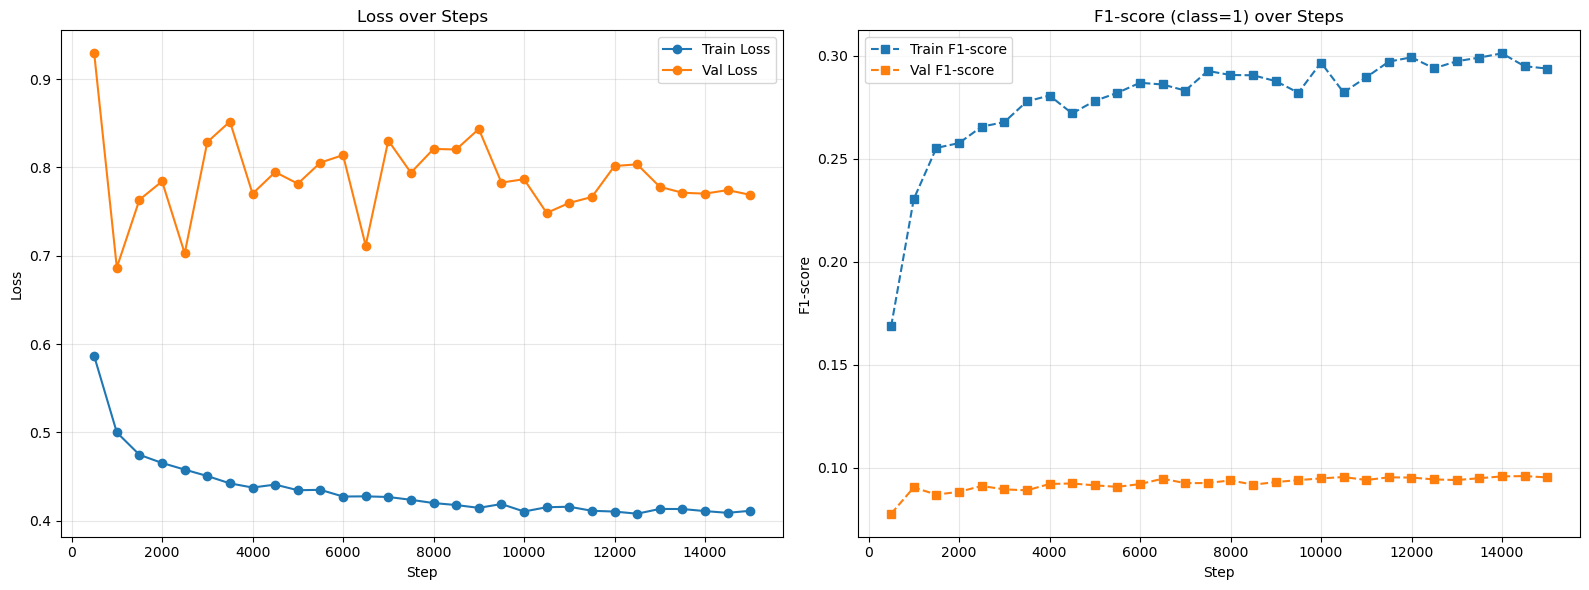

In [5]:
# plot_graph("/Users/rabinatwayana/1_Rabina/3_CDE_III/DLCV/project_2/kaggle_result/04_wight_false/metric_seg_s1_dem_20260126_071551/metrics.csv")
plot_graph("/kaggle/working/metrics/segformer_s1_dem_20260126_071551/metrics.csv")


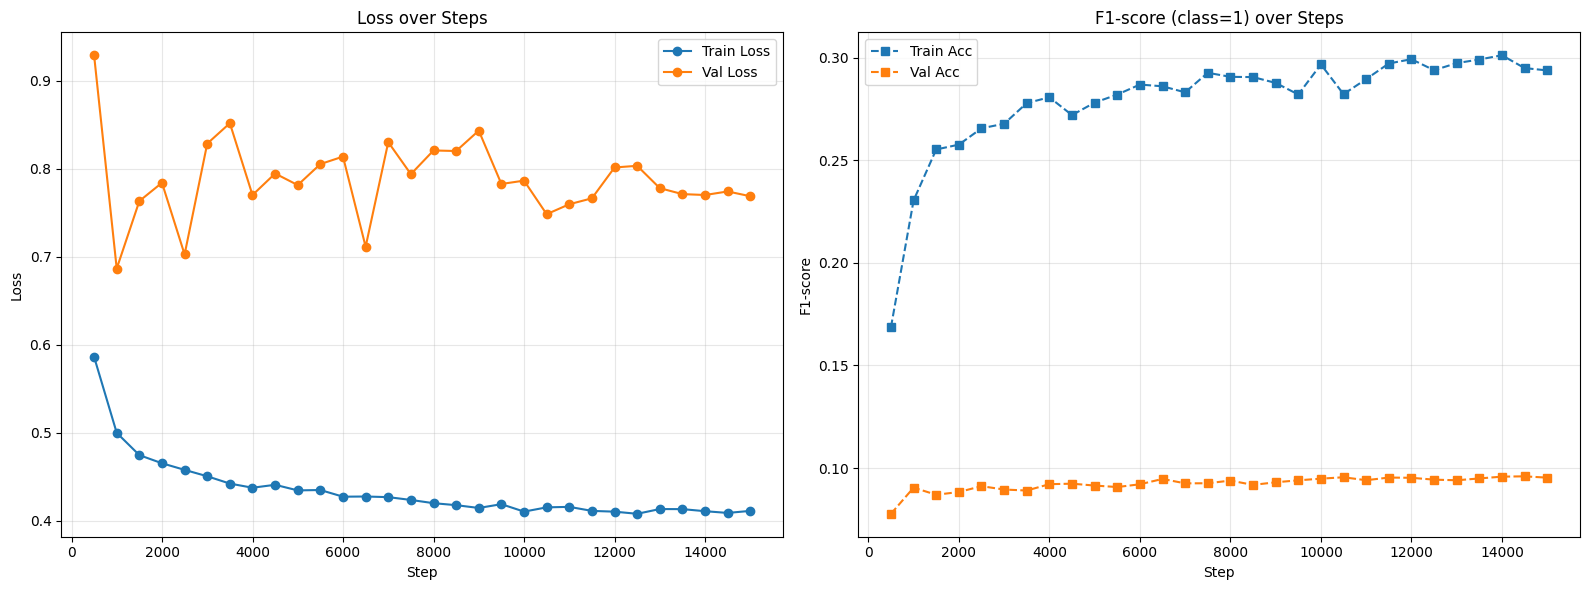

In [ ]:
# plot_graph("/kaggle/working/metrics/segformer_s1_dem_20260126_071551/metrics.csv")


In [16]:
import shutil

shutil.make_archive(
    "/kaggle/working/zipped/ckpt_seg_s1_dem_20260126_071551", 
    'zip', 
    "/kaggle/working/checkpoints/segformer_s1_dem_20260126_071551"
)

shutil.make_archive(
    "/kaggle/working/zipped/metric_seg_s1_dem_20260126_071551", 
    'zip', 
    "/kaggle/working/metrics/segformer_s1_dem_20260126_071551"
)

'/kaggle/working/zipped/metric_seg_s1_dem_20260126_071551.zip'

##

### Result Summary

Experiment setup
| Backbone      |Freeze Backbone |  Freeze Decoder| Weights (Imagenet)| Data Normalization|
|------------------|----|---|---|---|
|    mit_b0     | Yes|No|Yes|MMflood|
| mit_b0       | No|No|Yes|MMFlood|
| mit_b0      | Yes|No|Yes|Imagenet|
| mit_b0      | No|No|No|MMFlood|


Experiment Result

| Experiment Setup      |Total Prameter| Trainable Parameter| Train time| Precision (class=1)|Recall (class=1)|F1-score(class=1)|
|------------------|----|---|---|---|--|---|
| 1        | 3.7M|395K|6hr 5min|0.121|0.736|0.208|
| 2        | 3.7M|3.7M|2hr 27min|0.249|0.754|0.375|
| 3       | 3.7M|395K|-|0.060|0.741|0.111|
| 4      | 3.7M|3.7M|5hr 33min|0.049|0.747|0.093|




## References
Montello, F., Arnaudo, E., & Rossi, C. (2022). MMFlood: A Multimodal Dataset for Flood Delineation From Satellite Imagery. IEEE Access, 10, 96774–96787. https://doi.org/10.1109/ACCESS.2022.3205419

Xie, E., Wang, W., Yu, Z., Anandkumar, A., Alvarez, J. M., & Luo, P. (2021). SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers (No. arXiv:2105.15203). arXiv. https://doi.org/10.48550/arXiv.2105.15203


